In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pickle
saving_name = './persDistances.pkl'

import gudhi as gd
import gudhi.hera as hera
from gudhi.wasserstein import wasserstein_distance # no bottleneck because the implemented one doesn't have the correct internal p!
import torch
import torch.nn as nn
# import gudhi.wasserstein as wasserstein
from torch_topological import nn as topnn
torch.set_default_dtype(torch.float64)
inf = float('inf')

In [2]:
def generate_Datasets(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], size_dataset = [700,300]):
    # TRAIN
    train_dataset = np.zeros([size_dataset[0]*len(params), n_points_per_orbit, 2])
    for num_p, r in enumerate(params): # one class at the time
        for n_orb in range(size_dataset[0]): # all point clouds for each class
            id_orb = n_orb + num_p*size_dataset[0]
            xcur, ycur = np.random.rand(), np.random.rand() # init the first value for cloud computation
            for id_pt in range(n_points_per_orbit):
                xcur = (xcur + r * ycur * (1. - ycur)) % 1
                ycur = (ycur + r * xcur * (1. - xcur)) % 1
                train_dataset[id_orb, id_pt, :] = [xcur, ycur] # save the [x,y] point of the cloud
    train_labels = np.array([0]*size_dataset[0]+\
                            [1]*size_dataset[0]+\
                            [2]*size_dataset[0]+\
                            [3]*size_dataset[0]+\
                            [4]*size_dataset[0])
    # TEST
    test_dataset = np.zeros([size_dataset[1]*len(params), n_points_per_orbit, 2])
    for num_p, r in enumerate(params): # one class at the time
        for n_orb in range(size_dataset[1]): # all point clouds for each class
            id_orb = n_orb + num_p*size_dataset[1]
            xcur, ycur = np.random.rand(), np.random.rand() # init the first value for cloud computation
            for id_pt in range(n_points_per_orbit):
                xcur = (xcur + r * ycur * (1. - ycur)) % 1
                ycur = (ycur + r * xcur * (1. - xcur)) % 1
                test_dataset[id_orb, id_pt, :] = [xcur, ycur] # save the [x,y] point of the cloud
    test_labels = np.array([0]*size_dataset[1]+\
                            [1]*size_dataset[1]+\
                            [2]*size_dataset[1]+\
                            [3]*size_dataset[1]+\
                            [4]*size_dataset[1])
    return train_dataset, train_labels, test_dataset, test_labels

train_data, train_lab, test_data, test_lab = generate_Datasets(size_dataset = [700,10])

In [3]:
def get_persistences(train_clouds, test_clouds):

    train_persistences = []
    L = train_clouds.shape[0]
    for i in tqdm(range(L), desc = 'TRAIN PERS '):
        ac = gd.AlphaComplex(points=train_clouds[i,:,:])
        st = ac.create_simplex_tree()
        pers = st.persistence() # need to be run even if I won't use it
        pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()[:,:-1]
        lengths_0 = pers_0[1] - pers_0[0]
        sorted_indices_desc_0 = np.argsort(-lengths_0)
        sorted_pers_0 = pers_0[:,sorted_indices_desc_0]*1000
        
        pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()
        lengths_1 = pers_1[1] - pers_1[0]
        sorted_indices_desc_1 = np.argsort(-lengths_1)
        sorted_pers_1 = pers_1[:,sorted_indices_desc_1]*1000

        pers_dict = {
            'pers_0': sorted_pers_0,
            'pers_1': sorted_pers_1
        }
        train_persistences.append(pers_dict)
    
    test_persistences = []
    L = test_clouds.shape[0]
    for i in tqdm(range(L), desc = 'TEST PERS '):
        ac = gd.AlphaComplex(points=test_clouds[i,:,:])
        st = ac.create_simplex_tree()
        pers = st.persistence()
        pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()[:,:-1]
        lengths_0 = pers_0[1] - pers_0[0]
        sorted_indices_desc_0 = np.argsort(-lengths_0) #Get the indices that would sort the lengths array
        sorted_pers_0 = pers_0[:,sorted_indices_desc_0]*1000
        
        pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()
        lengths_1 = pers_1[1] - pers_1[0]
        sorted_indices_desc_1 = np.argsort(-lengths_1)
        sorted_pers_1 = pers_1[:,sorted_indices_desc_1]*1000

        pers_dict = {
            'pers_0': sorted_pers_0,
            'pers_1': sorted_pers_1
        }
        test_persistences.append(pers_dict)
    
    return train_persistences, test_persistences

train_pers, test_pers = get_persistences(train_data, test_data)

TEST PERS : 100%|██████████| 50/50 [00:01<00:00, 37.18it/s]


In [4]:
preproc_size = 600

# train_preproc_H0 = np.array([train_pers[i]['pers_0'][:,:preproc_size] for i in range(len(train_pers))])
# test_preproc_H0 = np.array([test_pers[i]['pers_0'][:,:preproc_size] for i in range(len(test_pers))])
#TRAIN
#H0
train_preproc_H0 = []
for i in range(len(train_pers)):
    pers_H0 = train_pers[i]['pers_0']
    current_length = pers_H0.shape[1]
    
    if current_length >= preproc_size:
        adjusted_array = pers_H0[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        adjusted_array = np.pad(pers_H0, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    train_preproc_H0.append(adjusted_array)
train_preproc_H0 = np.array(train_preproc_H0)
#H1
train_preproc_H1 = []
for i in range(len(train_pers)):
    pers_H1 = train_pers[i]['pers_1']
    current_length = pers_H1.shape[1]
    
    if current_length >= preproc_size:
        adjusted_array = pers_H1[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        adjusted_array = np.pad(pers_H1, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    train_preproc_H1.append(adjusted_array)
train_preproc_H1 = np.array(train_preproc_H1)

# TEST
#H0
test_preproc_H0 = []
for i in range(len(test_pers)):
    pers_H0 = test_pers[i]['pers_0']
    current_length = pers_H0.shape[1]
    
    if current_length >= preproc_size:
        adjusted_array = pers_H0[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        adjusted_array = np.pad(pers_H0, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    test_preproc_H0.append(adjusted_array)
test_preproc_H0 = np.array(test_preproc_H0)
#H1
test_preproc_H1 = []
for i in range(len(test_pers)):
    pers_H1 = test_pers[i]['pers_1']
    current_length = pers_H1.shape[1]
    
    if current_length >= preproc_size:
        adjusted_array = pers_H1[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        adjusted_array = np.pad(pers_H1, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    test_preproc_H1.append(adjusted_array)
test_preproc_H1 = np.array(test_preproc_H1)

## DISTANCES ABOUT PERSISTENCES: WASSERSTEIN DISTANCE

In [5]:
test_size = test_preproc_H0.shape[0]
H0_pers_distances = np.zeros((test_size, test_size))
H1_pers_distances = np.zeros((test_size, test_size))

p = 7

for i in range(test_size):
# for i in tqdm(range(test_size),desc = f'WASSERSTEIN DISTANCES with p = {p}'): # 2 mins each one....
    diag_H0_i = test_preproc_H0[i,:,:].transpose()
    diag_H1_i = test_preproc_H1[i,:,:].transpose()
    for j in tqdm(range(i,test_size)):
    # for j in range(i,test_size):
        diag_H0_j = test_preproc_H0[j,:,:].transpose()
        diag_H1_j = test_preproc_H1[j,:,:].transpose()
        # save distances in matrices
        dist_H0 = hera.wasserstein_distance(diag_H0_i, diag_H0_j, matching=False, order=p, internal_p=1)
        dist_H1 = hera.wasserstein_distance(diag_H1_i, diag_H1_j, matching=False, order=p, internal_p=1)
        H0_pers_distances[i,j] = dist_H0
        H0_pers_distances[j,i] = dist_H0
        H1_pers_distances[i,j] = dist_H1
        H1_pers_distances[j,i] = dist_H1

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 626.20it/s]


---
> COMPUTATION ABOUT PERSISTENCE DISTANCES ...

## STABLERANKS AND DISTANCES

In [6]:
stableranks_dict = {
    'train_H0': [],
    'train_H1': [],
    'test_H0': [],
    'test_H1': []
}
for key, dat in zip(stableranks_dict.keys(), [train_preproc_H0, train_preproc_H1, test_preproc_H0, test_preproc_H1]):
    stableranks_dict[key] = np.array([dat[i,1,:] - dat[i,0,:] for i in range(dat.shape[0])])
# stableranks_dict['train_H0'] = loaded_data['train_H0_preproc']
# stableranks_dict['train_H1'] = loaded_data['train_H1_preproc']
# stableranks_dict['test_H0'] = loaded_data['test_H0_preproc']
# stableranks_dict['test_H1'] = loaded_data['test_H1_preproc']

# check about means and std between train and test
mean_train_H0 = np.mean(stableranks_dict['train_H0'], axis=0)
std_train_H0 = np.std(stableranks_dict['train_H0'], axis=0)
mean_train_H1 = np.mean(stableranks_dict['train_H1'], axis=0)
std_train_H1 = np.std(stableranks_dict['train_H1'], axis=0)

mean_test_H0 = np.mean(stableranks_dict['test_H0'], axis=0)
std_test_H0 = np.std(stableranks_dict['test_H0'], axis=0)
mean_test_H1 = np.mean(stableranks_dict['test_H1'], axis=0)
std_test_H1 = np.std(stableranks_dict['test_H1'], axis=0)

# H0
print(f'{mean_train_H0.mean() = } - {mean_test_H0.mean() = }')
print(f'{std_train_H0.mean() = } - {std_test_H0.mean() = }')
# H1
print(f'{mean_train_H1.mean() = } - {mean_test_H1.mean() = }')
print(f'{std_train_H1.mean() = } - {std_test_H1.mean() = }')

# # test_size = loaded_data['original_test_data'].shape[0]
# DISTANCES
H0_SR_distances = np.zeros((test_size, test_size))
H1_SR_distances = np.zeros((test_size, test_size))

# for i in range(test_size):
for i in tqdm(range(test_size),desc = f'L_\infty DISTANCES among STABLE RANKS'): # 2 mins each one....
    sr_H0_i = stableranks_dict['test_H0'][i,:].transpose()
    sr_H1_i = stableranks_dict['test_H1'][i,:].transpose()
    # for j in tqdm(range(test_size)):
    for j in range(test_size):
        sr_H0_j = stableranks_dict['test_H0'][j,:].transpose()
        sr_H1_j = stableranks_dict['test_H1'][j,:].transpose()
        # L_infty distance!
        H0_SR_distances[i,j] = np.max(np.abs(sr_H0_i - sr_H0_j))
        H1_SR_distances[i,j] = np.max(np.abs(sr_H1_i - sr_H1_j))

mean_train_H0.mean() = 0.18683233101485044 - mean_test_H0.mean() = 0.18978242299087364
std_train_H0.mean() = 0.039786305172946304 - std_test_H0.mean() = 0.013660373300513744
mean_train_H1.mean() = 0.1782287704461303 - mean_test_H1.mean() = 0.18162244491341897
std_train_H1.mean() = 0.04404879209920761 - std_test_H1.mean() = 0.032643353267211926


L_\infty DISTANCES among STABLE RANKS: 100%|██████████| 50/50 [00:00<00:00, 595.97it/s]


DISTANCES BETWEEN PAIRS OF PERSISTENCES


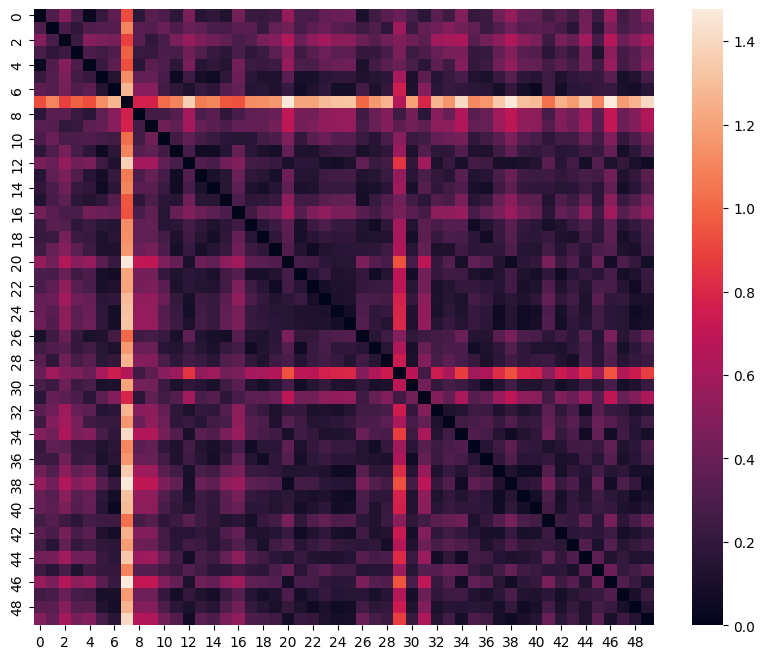

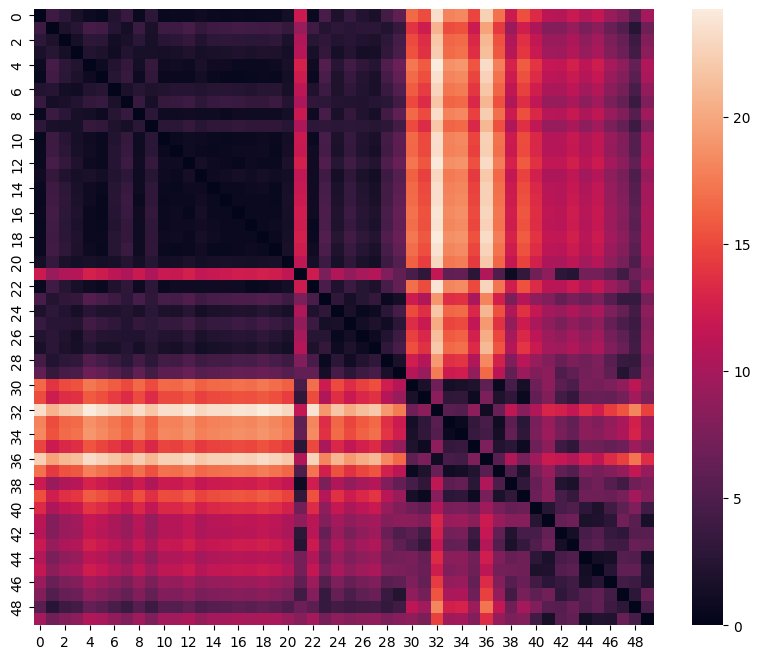

DISTANCES BETWEEN PAIRS OF STABERANKS


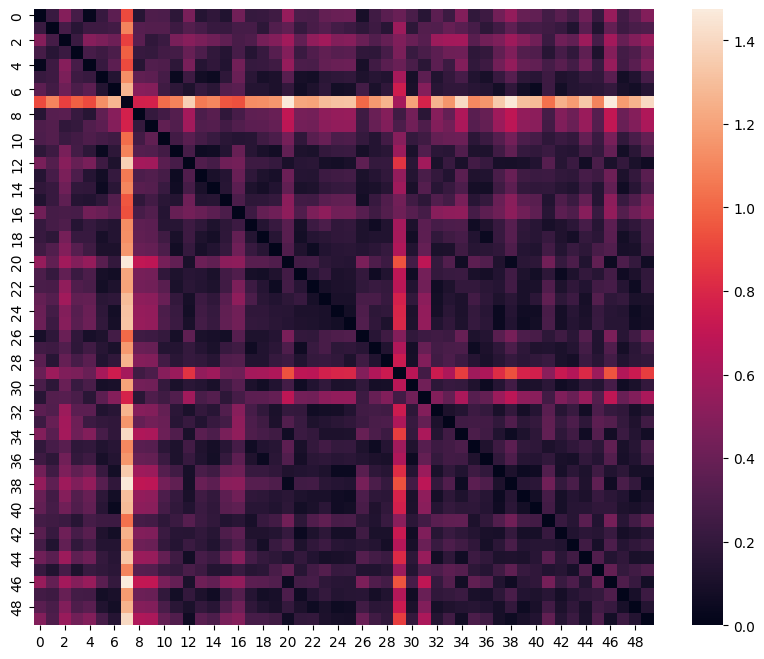

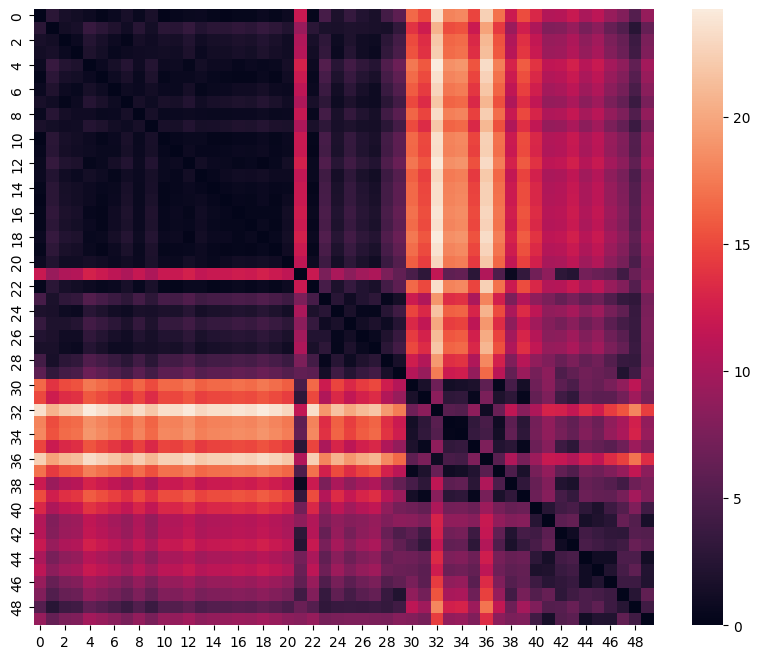

In [7]:
print('DISTANCES BETWEEN PAIRS OF PERSISTENCES')
plt.figure(figsize=(10,8))
sns.heatmap(H0_pers_distances)
# sns.heatmap(loaded_data['H0_dist_pers'])
plt.show()
plt.figure(figsize=(10,8))
sns.heatmap(H1_pers_distances)
# sns.heatmap(loaded_data['H1_dist_pers'])
plt.show()

print('DISTANCES BETWEEN PAIRS OF STABERANKS')
plt.figure(figsize=(10,8))
sns.heatmap(H0_SR_distances)
plt.show()
plt.figure(figsize=(10,8))
sns.heatmap(H1_SR_distances)
plt.show()

/tmp/ipykernel_423/1459363972.py:2: RuntimeWarning: invalid value encountered in divide
  result = np.divide(H0_SR_distances, H0_pers_distances)#, out=np.full_like(H0_SR_distances, np.nan), where=(loaded_data['H0_dist_pers']!= 0))


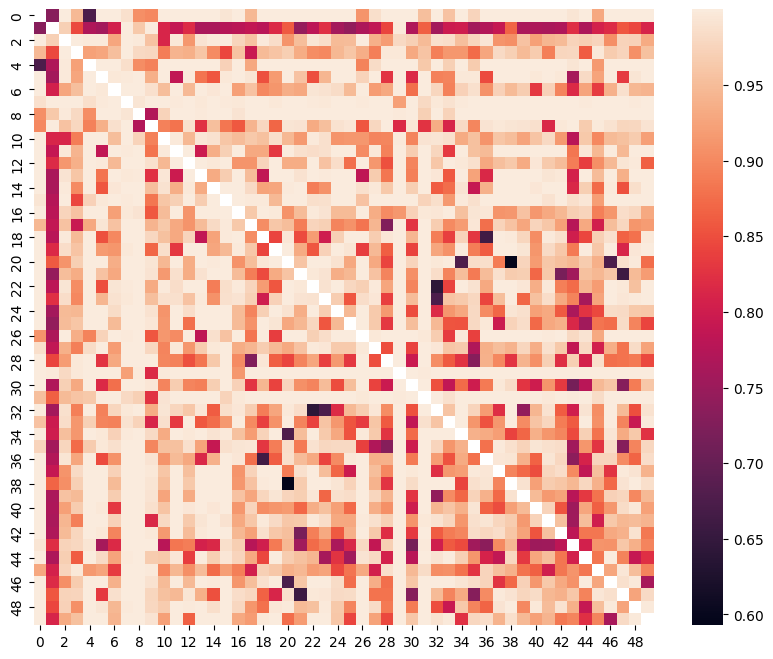

0.9999949335930088 \ (array([29, 34]), array([34, 29]))


In [8]:
# result = np.divide(H0_SR_distances, loaded_data['H0_dist_pers'])#, out=np.full_like(H0_SR_distances, np.nan), where=(loaded_data['H0_dist_pers']!= 0))
result = np.divide(H0_SR_distances, H0_pers_distances)#, out=np.full_like(H0_SR_distances, np.nan), where=(loaded_data['H0_dist_pers']!= 0))
plt.figure(figsize=(10,8))
sns.heatmap(result)
plt.show()
max_value = np.nanmax(result)
print(f'{ max_value } \ {np.where(result == max_value)}')


/tmp/ipykernel_423/3181474987.py:2: RuntimeWarning: invalid value encountered in divide
  result = np.divide(H1_SR_distances, H1_pers_distances)#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))


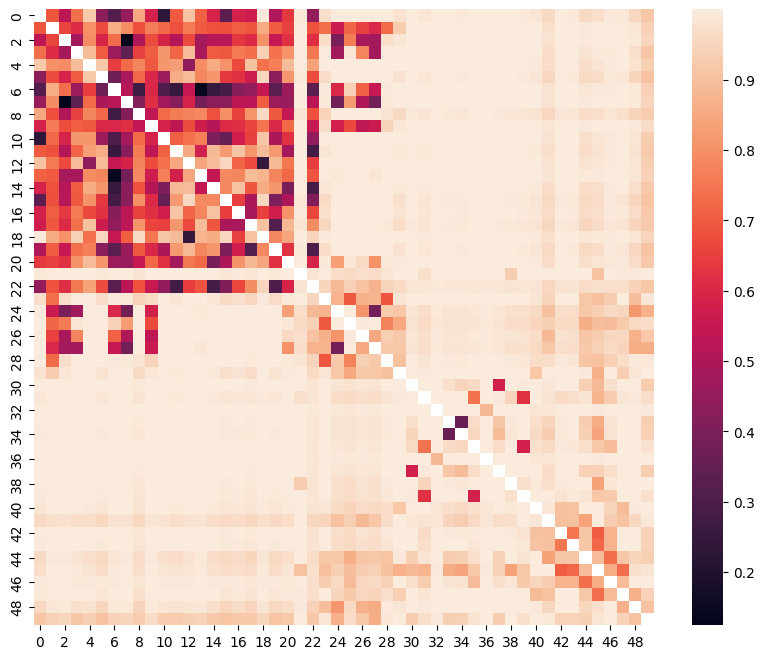

0.9999999880404661 \ (array([13, 32]), array([32, 13]))


In [9]:
# result = np.divide(H1_SR_distances, loaded_data['H1_dist_pers'])#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))
result = np.divide(H1_SR_distances, H1_pers_distances)#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))
plt.figure(figsize=(10,8))
sns.heatmap(result)
plt.show()
max_value = np.nanmax(result)
print(f'{ max_value } \ {np.where(result == max_value)}')


In [10]:
result_SW0 = np.divide(H0_SR_distances, H0_pers_distances)#, out=np.zeros_like(H0_SR_distances, dtype=float), where=(loaded_data['H0_dist_pers']!= 0))
# result_SW0 = np.divide(H0_SR_distances, loaded_data['H0_dist_pers'])#, out=np.zeros_like(H0_SR_distances, dtype=float), where=(loaded_data['H0_dist_pers']!= 0))
result_SW1 = np.divide(H1_SR_distances, H1_pers_distances)#, out=np.zeros_like(H1_SR_distances, dtype=float), where=(loaded_data['H1_dist_pers']!= 0))
# result_SW1 = np.divide(H1_SR_distances, loaded_data['H1_dist_pers'])#, out=np.zeros_like(H1_SR_distances, dtype=float), where=(loaded_data['H1_dist_pers']!= 0))
mask0 = result_SW0 >= 1
mask1 = result_SW1 >= 1
positions0 = np.argwhere(mask0)
positions1 = np.argwhere(mask1)
len(positions0), len(positions1)


/tmp/ipykernel_423/3670035420.py:1: RuntimeWarning: invalid value encountered in divide
  result_SW0 = np.divide(H0_SR_distances, H0_pers_distances)#, out=np.zeros_like(H0_SR_distances, dtype=float), where=(loaded_data['H0_dist_pers']!= 0))
/tmp/ipykernel_423/3670035420.py:3: RuntimeWarning: invalid value encountered in divide
  result_SW1 = np.divide(H1_SR_distances, H1_pers_distances)#, out=np.zeros_like(H1_SR_distances, dtype=float), where=(loaded_data['H1_dist_pers']!= 0))


(0, 0)

In [11]:
train_pds_H1 = [train_pers[i]['pers_1'] for i in range(len(train_pers))]

In [12]:
# H1 train persistent diagrams, ..., train_lab, test_lab
batch_size = 256

# shuffling data
combined = list(zip(train_pds_H1, stableranks_dict['train_H1'], train_lab))

# Shuffle the combined list
np.random.shuffle(combined)

# Unpack the shuffled list back into separate tensors
data1_shuffled, data2_shuffled, labels_shuffled = zip(*combined)

# Convert them back to PyTorch tensors
data1_shuffled = list(data1_shuffled)
data2_shuffled = torch.tensor(data2_shuffled)
labels_shuffled = torch.tensor(labels_shuffled)

L = stableranks_dict['train_H0'].shape[0]
n_batches = L//batch_size+1
shuffled_batched_train = []
for i in range(n_batches):
    shuffled_batched_train.append([data1_shuffled[i*batch_size:(i+1)*batch_size],\
                                   data2_shuffled[i*batch_size:(i+1)*batch_size],\
                            labels_shuffled[i*batch_size:(i+1)*batch_size]])

/tmp/ipykernel_423/4224436551.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  data2_shuffled = torch.tensor(data2_shuffled)


In [13]:
batched_train = []
for i in range(n_batches):
    batched_train.append([torch.tensor(stableranks_dict['train_H0'][i*batch_size:(i+1)*batch_size,:]),\
                        torch.tensor(stableranks_dict['train_H1'][i*batch_size:(i+1)*batch_size,:]),\
                        torch.tensor(train_lab[i*batch_size:(i+1)*batch_size])])

In [14]:
test_ds = [[torch.tensor(stableranks_dict['test_H0']),\
            torch.tensor(stableranks_dict['test_H1']),\
            torch.tensor(test_lab)]]

## NNs AND RESULTS

In [49]:
class linfLayer(nn.Module):
    def __init__(self, in_blocks, out_blocks, scaling = []):
        super().__init__()
        
        if len(scaling)==2:
            params = torch.randn((out_blocks, in_blocks)) * scaling[1] + scaling[0] # random*std + mean
            self.params = torch.nn.Parameter(data=params)
        elif len(scaling)==1:
            params = torch.randn((out_blocks, in_blocks)) * scaling[0] # random*std
            self.params = torch.nn.Parameter(data=params)
        else:
            params = torch.randn((out_blocks, in_blocks)) # only random in gaussian(mean=0, std=1)
            self.params = torch.nn.Parameter(data=params)

        # params = torch.randn((out_blocks, in_blocks)) * 0.05
        # self.params = torch.nn.Parameter(data=params)

    def forward(self, x, p):
        res = torch.cdist(x, self.params, p=p) #torch.cdist but with custom params
        return res
    

class linfModel(nn.Module):
    def __init__(self, sizes, scale):
        super().__init__()
        layers = [linfLayer(in_blocks=sizes[0], out_blocks=sizes[1], scaling=scale)]
        
        
        # Add hidden layers
        for i in range(2, len(sizes)):
            layers.append(linfLayer(in_blocks=sizes[i-1], out_blocks=sizes[i]))
        
        # Use ModuleList to hold the layers
        self.layers = nn.ModuleList(layers)

        # self.layer1_H = linfLayer(in_blocks=preproc_size, out_blocks=700, scaling=scale)
        # self.layer2_H = linfLayer(in_blocks=700, out_blocks=300)
        # self.layer3_H = linfLayer(in_blocks=300, out_blocks=80)
        # self.layer4_H = linfLayer(in_blocks=80, out_blocks=5)

    def forward(self, x, p):
        # Forward pass through all the layers
        for layer in self.layers[:-1]:
            x = layer(x, p)
            x = x - x.mean(axis=0)#.unsqueeze(1)
        out = self.layers[-1](x, p)
        return -out

    # def forward(self, h, p):
    #     h = self.layer1_H(h, p)
    #     h = h - h.mean(axis=0)
    #     h = self.layer2_H(h, p)
    #     h = h - h.mean(axis=0)
    #     h = self.layer3_H(h, p)
    #     h = h - h.mean(axis=0)
    #     h = self.layer4_H(h, p)
    #     return -h

In [50]:
# model_H0 = linfModel(preproc_size, scale=[mean_train_H0, std_train_H0])
sizes = [preproc_size, 1200, 700, 300, 80, 5]
model_H1 = linfModel(sizes, scale=[mean_train_H1, std_train_H1])
print(model_H1)

linfModel(
  (layers): ModuleList(
    (0-4): 5 x linfLayer()
  )
)


In [51]:
epochs = 150
inf=float("inf")

p_schedule = np.ones(epochs)*inf

# e1, e2 = 20,40 # e1+e2 < epochs !!
# p_schedule = np.ones(epochs)*8
# p_schedule[e1:e1+e2] = np.linspace(8, 100, e2)
# p_schedule[e1+e2:] = inf

save_folder = f'./LinfModels/'

def test_model(model, test_data, H, if_plot):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for h0, h1, cl in test_data:
            # h1 = torch.tensor(h1)
            # cl = torch.tensor(cl)

            # Forward pass
            if H==0:
                outputs = model(h0, p_schedule[i])
            else:
                outputs = model(h1, p_schedule[i])
                
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += cl.size(0)
            # Total correct predictions
            correct += (predicted == cl).sum().item()
            target_labs = np.append(target_labs, cl)
            pred_labs = np.append(pred_labs, predicted)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    return accuracy

 ############# H = 1 ############# 
Epoch   1/150 --> IMPROVEMENT from 0.000 to 76.000 	
Epoch   2/150 --> IMPROVEMENT from 76.000 to 84.000 	
 Epoch 150	loss : 0.53891, p: inf

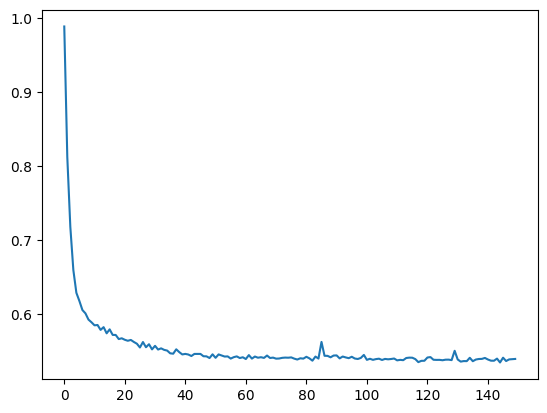

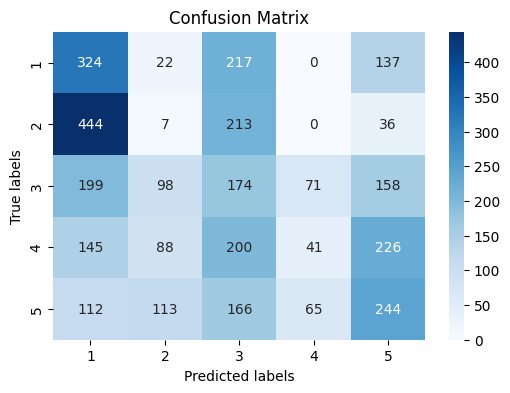

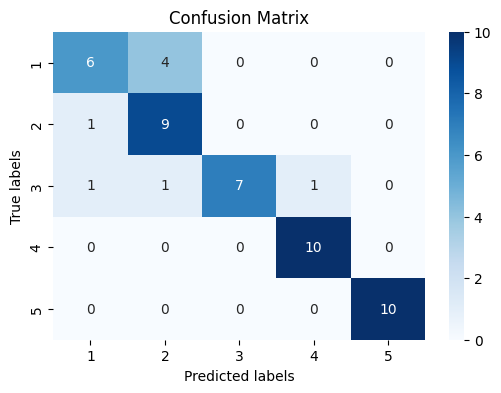

(22.571428571428573, 84.0)

In [52]:
# from torch.optim.lr_scheduler import StepLR
loss_fn = nn.CrossEntropyLoss()

H = 1
print(f' ############# {H = } ############# ')

# models = [model_H0, model_H1]
model = model_H1
# model = model_H1

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05, eps=1e-06)
# scheduler = StepLR(optimizer, step_size=40, gamma=0.95)
# list(model.parameters())[0].shape
losses = []
best_acc = 0.0
best_model_params = 0

for i in range(epochs):
    for (h0, h1, cl) in shuffled_batched_train:
        # h1 = torch.tensor(h1)
        # cl = torch.tensor(cl)
        model.train()
        tot_loss = 0.0
        
        #calculate output
        if H == 0:
            output = model(h0, p_schedule[i])
        else:
            output = model(h1, p_schedule[i])

        #calculate loss
        loss = loss_fn(output, cl.long())

        #backprop
        optimizer.zero_grad()
        tot_loss += float(loss)
        loss.backward()
        optimizer.step()
        # scheduler.step()
    
    losses.append(tot_loss)
    test_acc = test_model(model, test_ds, H, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 70.0:
            best_model_params = model.state_dict()
            torch.save(best_model_params, save_folder + f'H{H}_{preproc_size}_acc_{test_acc:.3f}.pth')
        print(f'\rEpoch {i+1:3}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t')
        best_acc = test_acc
    else:
        # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
        print(f"\r Epoch {i+1:3}\tloss : {loss:.5f}, p: {p_schedule[i]}", end='')

plt.plot(np.array(losses))
train_acc = test_model(model, batched_train, H, if_plot=True)
test_acc = test_model(model, test_ds, H, if_plot=True)
train_acc, test_acc

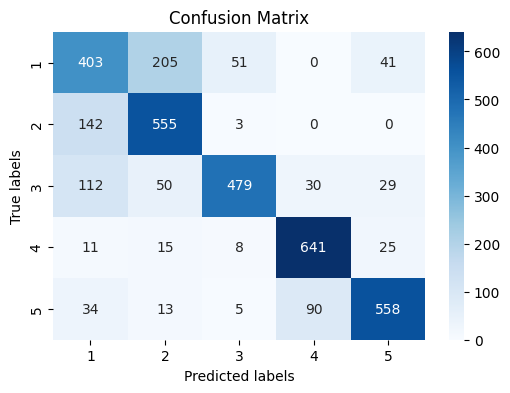

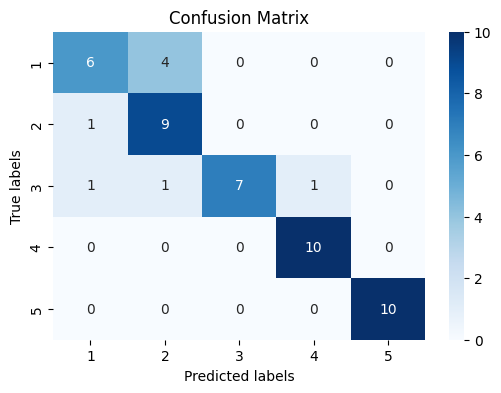

(75.31428571428572, 21.714285714285715, 84.0)

In [54]:
# model.load_state_dict(best_model_params)
model_str = save_folder + 'H1_600_acc_84.000.pth'
saved_params = torch.load(model_str)
model.load_state_dict(saved_params)
shuffled_train_acc = test_model(model, shuffled_batched_train, H, if_plot=True)
# train_acc = test_model(model, batched_train, H, if_plot=True)
test_acc = test_model(model, test_ds, H, if_plot=True)
shuffled_train_acc, train_acc, test_acc # different values....

In [20]:
# ADVERSARIAL EXAMPLES!!!
# Take the first batch of train axamples
# - each sample is composede by (h1_pers, h1_sr, class)
# We pass the batch in the NN and check if they are correctly classified

# We can work on those that are correctly classified:
# - (first attempt without adding bars!)
# - Create a loss
# - Define a Wass Distance(1,1)
# - topnn.PersistenceInformation on h1_pers
# - create tensor to be optimized and pass it in the optimizer(Adam)
# - Fix 'n_iterations' as upper bound for tries to find adversarial examples
# - Perturb the persistence, compute the stablerank and pass it in the NN
# - Compute the NN loss for the perturbed tensor
# - store persInformations
# - loss_h1 with wass(p,q)
# - save.


In [64]:
len(shuffled_batched_train[0])


3

In [71]:
batch_samples = shuffled_batched_train[0] # first batch of shuffled training dataset

output_batch_samples = model(batch_samples[1], inf) # all h1 in the NN

#params
max_num_samples = 30
lamb = 10
wass_p = 1
wass_q = 1
n_added_bars = 0 # don't want to use it now
n_iters = 50
lr = 0.5
eps = 1e-06

dict_adv_samples = {}
# input_nn = shuffled_batched_train[0]

for sample in range(min(len(output_batch_samples), max_num_samples)): #test for each sample (need some correctly classified samples)
    print(f'>>> {sample = }')

    # we have a correpondance [batch_samples > output_batch_samples]:
    # Fixing i:
    pers_h1_i = torch.tensor(batch_samples[0][sample]) # pers H1 diagram
    # fix persistence to the shape[2, preproc_size]
    current_length = pers_h1_i.shape[1]
    if current_length >= preproc_size:
        pers_h1_i = pers_h1_i[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        pers_h1_i = np.pad(pers_h1_i, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    h1_i = batch_samples[1][sample] # stablerank H1
    real_class_i = batch_samples[2][sample] # real class
    out_h1_i = output_batch_samples[sample] # predicted class
    # print(f'{pers_h1_i.shape = }')
    dict_adv_samples[sample] = []

    if real_class_i == torch.argmax(out_h1_i): # if class == pred_class:
        # define the loss and wass distance
        loss_f = nn.CrossEntropyLoss()
        wass = topnn.WassersteinDistance(p = wass_p, q = wass_q)

        sample_PI_h1 = topnn.PersistenceInformation(None, pers_h1_i.T) # .T needed for computations

        # create differentiable tensors!
        adv_pers_h1 = pers_h1_i.clone() # copy the pers_diagram
        adv_pers_h1.requires_grad = True
        optim = torch.optim.Adam(params=[adv_pers_h1], lr=lr, eps=eps)

        losses_h1, losses_nn, losses_cum, adv_classes = [np.zeros(n_iters) for _ in range(4)]

        # store adv we'll find below
        adv_samples = []
        for it in range(n_iters):
            # compute the stablerank from the perturbation
            adv_sr_h1 = adv_pers_h1[1] - adv_pers_h1[0] # bars already sorted!!

            ## put the new stablerank in the batch to make normalization between layers working properly
            input_NN = batch_samples[1].clone()
            input_NN[sample] = adv_sr_h1
            output_pert = model(input_NN, inf)[sample]
            pert_class = torch.argmax(output_pert)
            nn_loss = - loss_f(output_pert, real_class_i)

            adv_PI_h1 = topnn.PersistenceInformation(None, adv_pers_h1.T)
            h1_loss = wass(sample_PI_h1, adv_PI_h1)

            if it==0:
                comb_loss = nn_loss
            else:
                comb_loss = nn_loss + lamb*h1_loss

            losses_h1[it], losses_nn[it], losses_cum[it], adv_classes[it] = h1_loss.item(), nn_loss.item(), comb_loss.item(), pert_class.item()
            
            if pert_class != real_class_i:
                adv_samples.append([adv_pers_h1, pert_class.item(), h1_loss.item(), nn_loss.item(), comb_loss.item()])


            # Get gradients and take step
            optim.zero_grad()
            comb_loss.backward()
            optim.step()
        # using a dict with the index as key we maintain the corrspondance as for batch_samples and output_batch_samples
        dict_adv_samples[sample].append(adv_samples)
        print('- done -')
    else:
        print('- misclassified -')

>>> sample = 0
>>> sample = 1
>>> sample = 2
>>> sample = 3
>>> sample = 4
>>> sample = 5
>>> sample = 6
>>> sample = 7
>>> sample = 8
>>> sample = 9
>>> sample = 10
>>> sample = 11
>>> sample = 12
>>> sample = 13
>>> sample = 14
>>> sample = 15
>>> sample = 16
>>> sample = 17
>>> sample = 18
>>> sample = 19
>>> sample = 20
>>> sample = 21
>>> sample = 22
>>> sample = 23
>>> sample = 24
>>> sample = 25
>>> sample = 26
>>> sample = 27
>>> sample = 28
>>> sample = 29
>>> sample = 30
>>> sample = 31


KeyboardInterrupt: 

In [129]:
sample = 10
num_adv_samples = len(dict_adv_samples[sample][0])
print(f'Number of counter examples for sample {sample} = {num_adv_samples}')
sample_class = batch_samples[2][sample]
adv_classes = [dict_adv_samples[sample][0][adv][1] for adv in range(num_adv_samples)]
print(f'Classes of the chosen sample: {sample_class.item() }')
print(f'Classes of adv_samples: {adv_classes}')



Number of counter examples for sample 10 = 48
Classes of the chosen sample: 0
Classes of adv_samples: [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4]


In [130]:
len(dict_adv_samples[sample][0])
dict_adv_samples[sample][0][1]

# lower bound/margin?

[tensor([[1.0554, 0.2453, 0.8249,  ..., 0.1323, 0.2563, 0.3407],
         [1.1809, 0.7164, 2.6835,  ..., 0.3514, 0.2237, 0.6439]],
        requires_grad=True),
 2,
 4.065310605646697,
 -1.4071210257404507,
 39.24598503072652]

In [120]:
adv_first = dict_adv_samples[sample][0][0][0].detach().numpy() # h1 persistence, class, h1_loss, nn_loss, compound_loss
adv_second = dict_adv_samples[sample][0][3][0].detach().numpy() # h1 persistence
adv_third = dict_adv_samples[sample][0][-1][0].detach().numpy() # h1 persistence
np.max( np.abs(adv_first - adv_second))
               
               
# adv_third

0.0

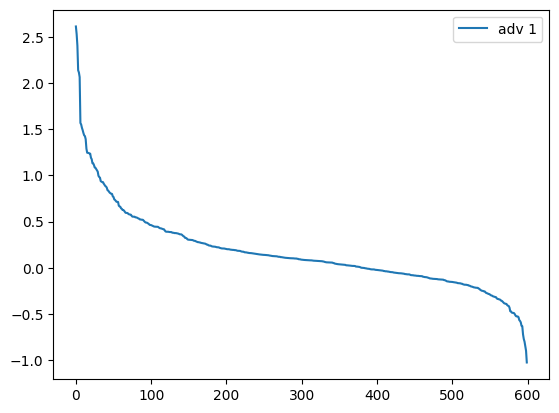

In [134]:
# compute the stableranks of these counterexamples
sr_first = adv_first[1] - adv_first[0]
sr_second = adv_second[1] - adv_second[0]
sr_third = adv_third[1] - adv_third[0]
plt.plot(sorted(sr_first)[::-1], label = 'adv 1')
# plt.plot(sorted(sr_second)[::-1], label = 'adv 2')
# plt.plot(sorted(sr_third)[::-1], label = 'adv 3')
plt.legend()
plt.show()

In [24]:
saving_dict = {
    # 'H0_dist_pers': H0_pers_distances,
    # 'H1_dist_pers': H1_pers_distances,
    # 'p' : p,
    
    'original_train_data': train_data,
    'train_lab': train_lab,
    'train_H0_preproc': train_preproc_H0,
    'train_H1_preproc': train_preproc_H1,

    'original_test_data': test_data,
    'test_lab': test_lab,
    'test_H0_preproc': test_preproc_H0,
    'test_H1_preproc': test_preproc_H1,

    'shuffled_batched_train': shuffled_batched_train,
    'batched_train': batched_train,
    'test_ds': test_ds,
    'model_params': model.state_dict(),
    'model_str' : save_folder + 'H1_600_acc_80.000.pth',

    'dict_adv_samples': dict_adv_samples,
    'batch_samples': batch_samples,
    'output_batch_samples': output_batch_samples
    
}

# Save data to a pickle file
with open(saving_name, 'wb') as file:
    pickle.dump(saving_dict, file)

print(f"Data has been saved to {saving_name}")

# ##* TO LOAD DATA
# # Load data from the pickle file
# # file_name = './wass_dist_fixed'
# file_name = './persDistances.pkl'

# with open(file_name, 'rb') as file:
#     loaded_data = pickle.load(file)

# print(f"Data has been loaded from {file_name}")

Data has been saved to ./persDistances.pkl


> NN OUTPUT TESTS

In [25]:
for k in saved_params.keys():
    print(f'[{k = }] -> {saved_params[k].shape = }')
###  WOWWW!!

[k = 'layers.0.params'] -> saved_params[k].shape = torch.Size([1200, 600])
[k = 'layers.1.params'] -> saved_params[k].shape = torch.Size([700, 1200])
[k = 'layers.2.params'] -> saved_params[k].shape = torch.Size([300, 700])
[k = 'layers.3.params'] -> saved_params[k].shape = torch.Size([80, 300])
[k = 'layers.4.params'] -> saved_params[k].shape = torch.Size([5, 80])


In [26]:
# IF NEEDED!
model_str = save_folder + 'H1_400_acc_84.000.pth'
saved_params = torch.load(model_str)
# model.load_state_dict(saved_params)

for (h0, h1, cl) in test_ds: # 1 batch
    model.eval()
    test_output = model(h1, inf)
print(test_output.shape)
outNN_distances = torch.cdist(test_output, test_output, p=inf).detach().numpy()

torch.Size([50, 5])


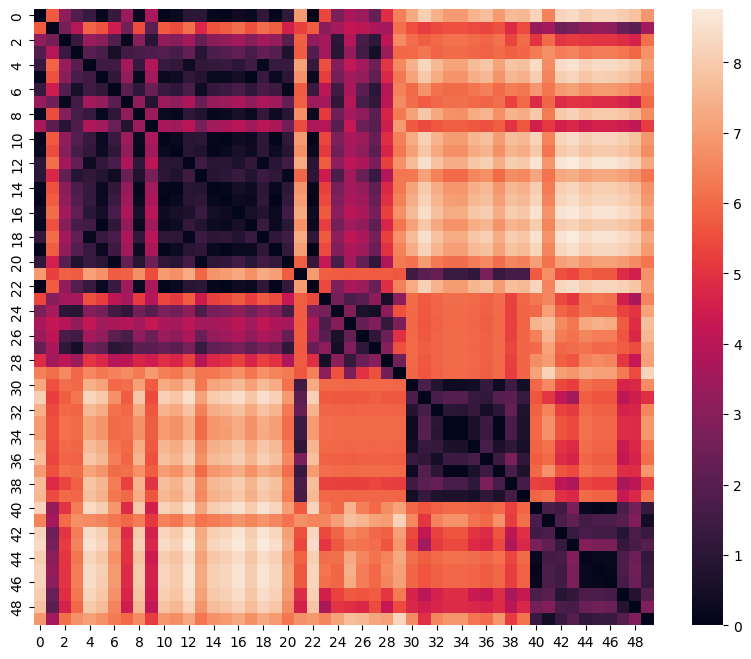

0.9999999880404661 \ (array([13, 32]), array([32, 13]))


In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(outNN_distances)
plt.show()
max_value = np.nanmax(result)
print(f'{ max_value } \ {np.where(result == max_value)}')


/tmp/ipykernel_423/3380249966.py:1: RuntimeWarning: invalid value encountered in divide
  result = np.divide(outNN_distances, H1_SR_distances)#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))


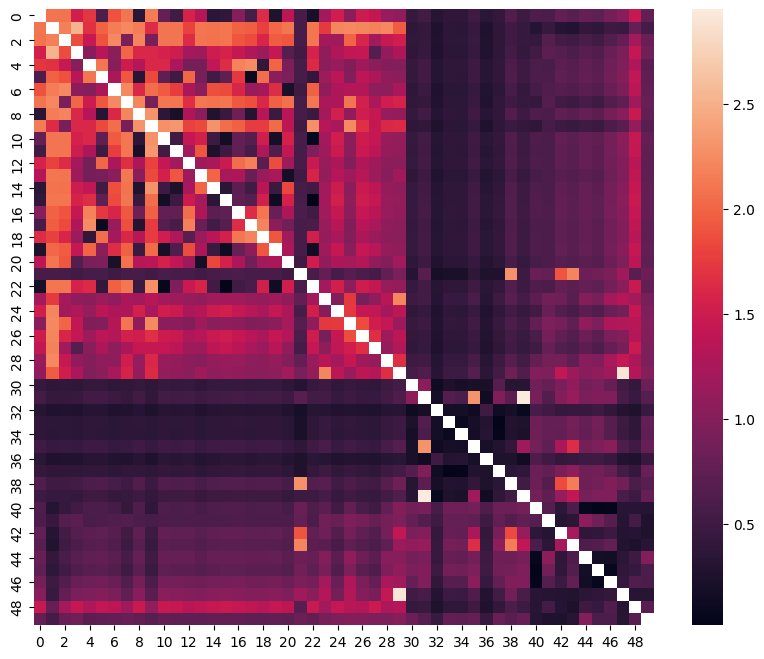

2.9482177769822107 \ (array([31, 39]), array([39, 31]))


In [28]:
result = np.divide(outNN_distances, H1_SR_distances)#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))
plt.figure(figsize=(10,8))
sns.heatmap(result)
plt.show()
max_value = np.nanmax(result)
print(f'{ max_value } \ {np.where(result == max_value)}')


- Distribution of the margins, only for correct classifications, for both train and test sets
- Average/min intra and inter-classes

Handcrafted adversarial example: start from sample with correct classification, inject bar s.t. Wasserstein between perturbed and original will be smaller than the radius. 

Check that it's actually correctly classified and how the output looks.

### MARGIN COMPUTATION

In [29]:
# non shuffled data
L = stableranks_dict['train_H1'].shape[0]
n_batches = L//batch_size +1
batched_train = []
for i in range(n_batches):
    batched_train.append([torch.tensor(stableranks_dict['train_H0'][i*batch_size:(i+1)*batch_size,:]),\
                        torch.tensor(stableranks_dict['train_H1'][i*batch_size:(i+1)*batch_size,:]),\
                        torch.tensor(train_lab[i*batch_size:(i+1)*batch_size])])

test_ds = [[torch.tensor(stableranks_dict['test_H0']),\
            torch.tensor(stableranks_dict['test_H1']),\
            torch.tensor(test_lab)]]

In [30]:
# on training dataset, but then also test
train_output = torch.tensor([])
train_labels = torch.tensor([])
for (h0, h1, cl) in shuffled_batched_train: # 1 batch
    model.eval()
    train_out = model(h1, inf)
    train_output = torch.concat((train_output, train_out), axis=0)
    train_labels = torch.concat((train_labels, cl), axis=0)
train_output = train_output.detach().numpy()
train_labels = train_labels.detach().numpy()

test_output = torch.tensor([])
for (h0, h1, cl) in test_ds: # 1 batch
    model.eval()
    test_out = model(h1, inf)
    test_output = torch.concat((test_output, test_out), axis=0)
test_output = test_output.detach().numpy()

train_output.shape, train_labels.shape, test_output.shape

((3500, 5), (3500,), (50, 5))

In [31]:
train_output[:3], train_labels[:3], test_output[:3], test_lab[:3]

(array([[ -9.53765576,  -9.23175644,  -2.37957792,  -7.82979341,
          -8.55877522],
        [ -3.99956138,  -3.88583562,  -5.13376372,  -7.77911224,
          -7.43465119],
        [ -8.36185887, -10.96245477,  -4.49245431,  -2.26163571,
          -6.76455802]]),
 array([2., 1., 3.]),
 array([[-3.98434265, -3.41590815, -5.14874847, -7.76389351, -7.51085624],
        [-4.20152017, -9.13610238, -6.37234462, -7.3302968 , -4.56600852],
        [-3.67361629, -6.58928183, -5.37539966, -7.90124495, -7.17710126]]),
 array([0, 0, 0]))

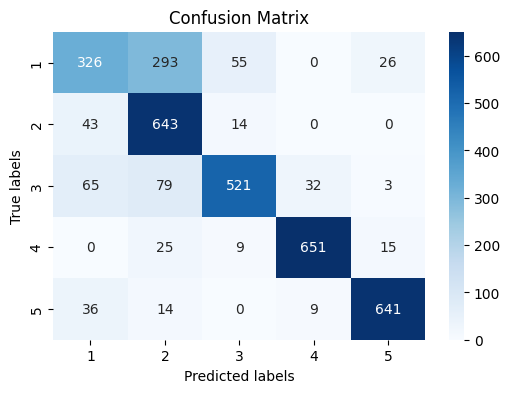

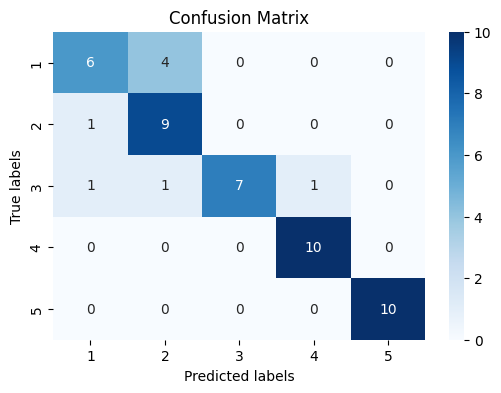

(79.48571428571428, 84.0)

In [32]:
train_acc = test_model(model, shuffled_batched_train, 1, True)
test_acc = test_model(model, test_ds, 1, True)
train_acc, test_acc

In [33]:
sorted_train_output = np.sort(-train_output, axis=1)
all_train_margins = np.abs(sorted_train_output[:,1] - sorted_train_output[:,0])/2
np.min(all_train_margins), np.max(all_train_margins), np.mean(all_train_margins)

(0.001175678847585182, 3.058295662821203, 1.1316333897702116)

(array([201., 220., 465., 221., 195., 209., 181.,  73.,  57.,  68.,  52.,
         46.,  55.,  56.,  71., 122.,  56.,  58.,  60.,  86., 354., 138.,
        114.,  74.,  82.,  98.,  33.,  21.,  14.,  20.]),
 array([1.17567885e-03, 1.03079678e-01, 2.04983678e-01, 3.06887677e-01,
        4.08791677e-01, 5.10695676e-01, 6.12599676e-01, 7.14503675e-01,
        8.16407675e-01, 9.18311674e-01, 1.02021567e+00, 1.12211967e+00,
        1.22402367e+00, 1.32592767e+00, 1.42783167e+00, 1.52973567e+00,
        1.63163967e+00, 1.73354367e+00, 1.83544767e+00, 1.93735167e+00,
        2.03925567e+00, 2.14115967e+00, 2.24306367e+00, 2.34496767e+00,
        2.44687167e+00, 2.54877567e+00, 2.65067966e+00, 2.75258366e+00,
        2.85448766e+00, 2.95639166e+00, 3.05829566e+00]),
 <BarContainer object of 30 artists>)

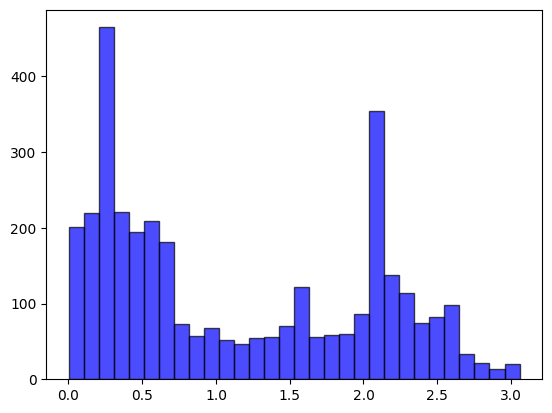

In [34]:
plt.hist(all_train_margins, bins=30, color='blue', edgecolor='black', alpha=0.7)

In [35]:
train_pred_classes = np.argmax(train_output, axis=1)
train_correct_pred = train_pred_classes == train_labels

# Number of correct predictions
train_correct_indices = np.where(train_correct_pred)[0]
num_train_correct_pred = np.sum(train_correct_pred)
print(f"{num_train_correct_pred = }")

num_train_correct_pred = 2782


In [36]:
# extract a stablerank
sr_index_fixed = train_correct_indices[7] # change index just to change the fixed stablerank you are working on
which_batch = sr_index_fixed // batch_size
which_in_the_batch = sr_index_fixed % batch_size
# which_batch, which_in_the_batch # check values
# distance of the stablerank from others
sr_fixed = shuffled_batched_train[which_batch][1][which_in_the_batch].detach().numpy()
sr_fixed_label = shuffled_batched_train[which_batch][2][which_in_the_batch].detach().numpy()
# margin of sr_fixed according to the output of the NN
model.eval()
out_sr_fixed = model(torch.tensor([sr_fixed]), inf).squeeze().detach().numpy()
sort_out_sr_fixed = np.sort(out_sr_fixed)[::-1]
sr_fixed_margin = (sort_out_sr_fixed[0] - sort_out_sr_fixed[1])/2

> adversarial examples
- changing few bars
- epsilon perturbation

Actual sr_fixed label = 3
Actual sr_fixed margin = 2.070621811895719
Stableranks distance [BAR] = 9.157420006561821
Stableranks distance [EPS] = 1.2888071535099774


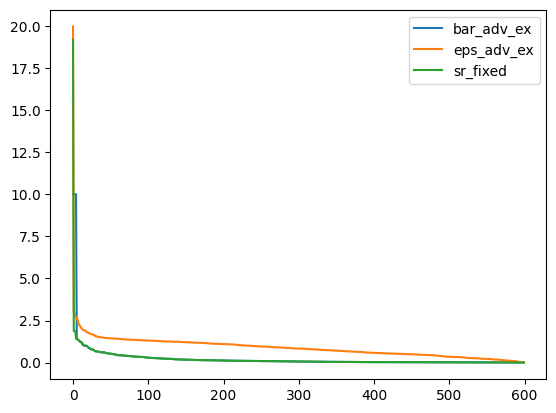

out_bar_adv_ex label = 4
NN_Outputs distance [BAR] = 5.280050821474848
out_eps_adv_ex label = 3
NN_Outputs distance [EPS] = 2.7394582312893867


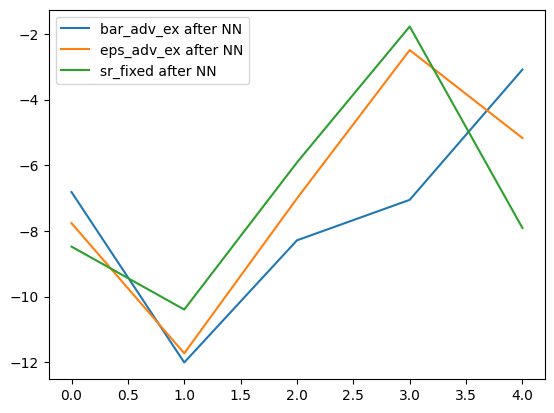

In [37]:
print(f'Actual sr_fixed label = {sr_fixed_label}')
print(f'Actual sr_fixed margin = {sr_fixed_margin}')

# change a bar
sr_bar_adv_ex = sr_fixed.copy()
sr_bar_adv_ex[:5] = 10.
sr_bar_adv_ex = sorted(sr_bar_adv_ex)[::-1]
print(f'Stableranks distance [BAR] = {np.max(np.abs(sr_fixed - sr_bar_adv_ex))}')

# epsilon_perturbation
epsilon = sr_fixed_margin/1.5 # 0.5
perturbations = np.random.uniform(0, epsilon, size=sr_fixed.shape)
# perturbations = np.random.uniform(-epsilon, epsilon, size=sr_fixed.shape)
perturbations.shape
sr_eps_adv_ex = np.sort(sr_fixed.copy() + perturbations)[::-1]
np.sum(sr_eps_adv_ex<0)
print(f'Stableranks distance [EPS] = {np.max(np.abs(sr_fixed - sr_eps_adv_ex))}')


plt.plot(sr_bar_adv_ex, label = 'bar_adv_ex')
plt.plot(sr_eps_adv_ex, label = 'eps_adv_ex')
plt.plot(sr_fixed, label = 'sr_fixed')
plt.legend()
plt.show()

# NN Computations
out_bar_adv_ex = model(torch.tensor([sr_bar_adv_ex]), inf).squeeze().detach().numpy()
out_eps_adv_ex = model(torch.tensor([sr_eps_adv_ex]), inf).squeeze().detach().numpy()
print(f'out_bar_adv_ex label = {np.argmax(out_bar_adv_ex)}')
print(f'NN_Outputs distance [BAR] = {np.max(np.abs(out_sr_fixed - out_bar_adv_ex))}')
print(f'out_eps_adv_ex label = {np.argmax(out_eps_adv_ex)}')
print(f'NN_Outputs distance [EPS] = {np.max(np.abs(out_sr_fixed - out_eps_adv_ex))}')
plt.plot(out_bar_adv_ex, label = 'bar_adv_ex after NN')
plt.plot(out_eps_adv_ex, label = 'eps_adv_ex after NN')
plt.plot(out_sr_fixed, label = 'sr_fixed after NN')
plt.legend()
plt.show()

(tensor(0.0224, grad_fn=<MeanBackward0>),
 tensor(-5.8990, grad_fn=<MinBackward1>),
 tensor(6.4172, grad_fn=<MaxBackward1>))

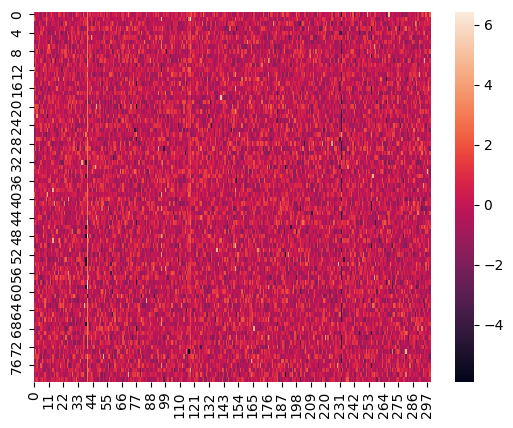

In [38]:
lay = 3
sns.heatmap(model.layers[lay].params.detach().numpy())
torch.mean(model.layers[lay].params), torch.min(model.layers[lay].params), torch.max(model.layers[lay].params)

############## PRE NN ##############


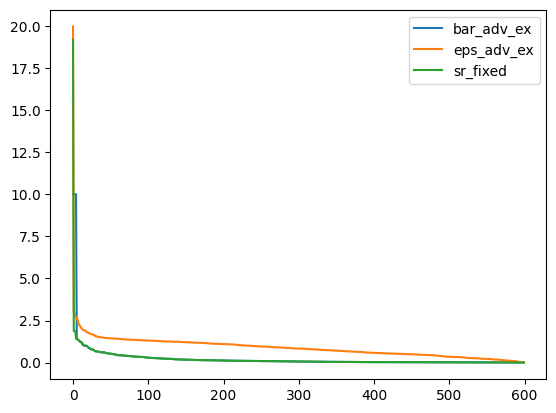

############## 0 ##############
LAYER SIZE : (1200,)


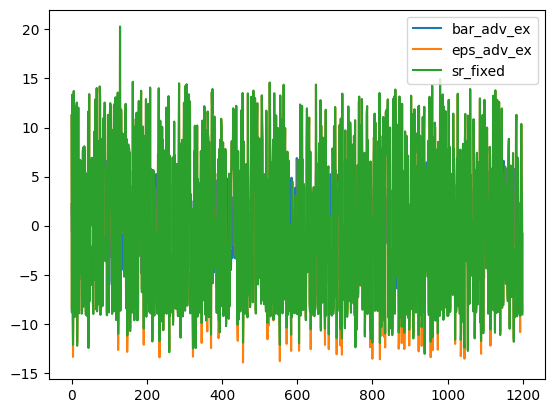

############## 1 ##############
LAYER SIZE : (700,)


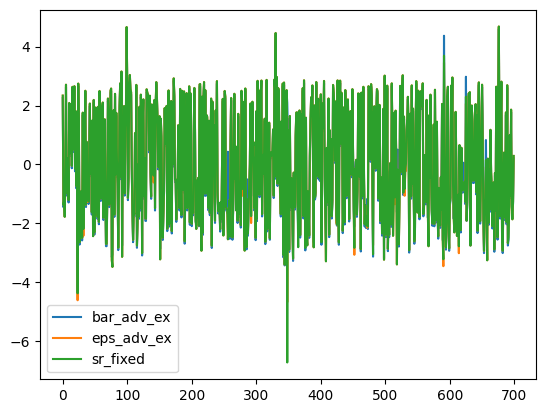

############## 2 ##############
LAYER SIZE : (300,)


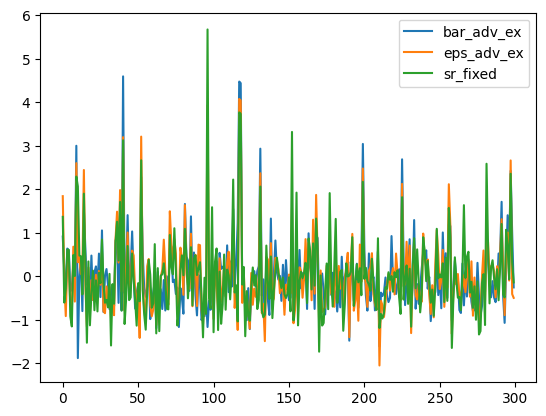

############## 3 ##############
LAYER SIZE : (80,)


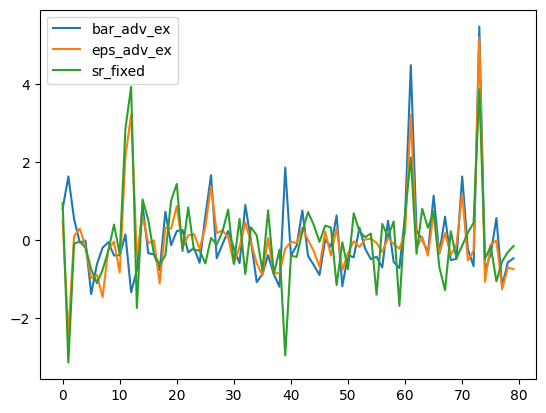

############## 4 ##############
LAYER SIZE : (5,)


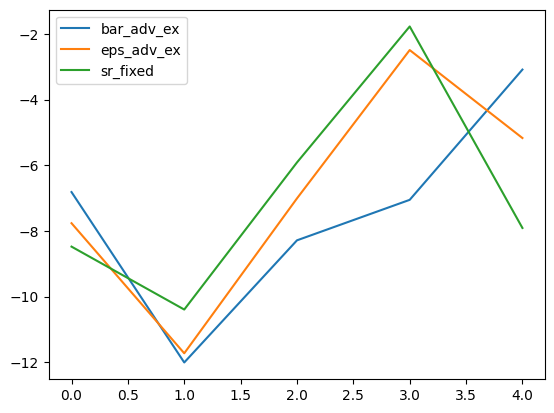

In [39]:
ex1 = sr_fixed
ex2 = np.array(sr_bar_adv_ex)
ex3 = np.array(sr_eps_adv_ex)
print(f'############## PRE NN ##############')
plt.plot(ex2, label = 'bar_adv_ex')
plt.plot(ex3, label = 'eps_adv_ex')
plt.plot(ex1, label = 'sr_fixed')
plt.legend()
plt.show()

for i in range(len(model.layers)):
    print(f'############## {i} ##############')
    ex1 = model.layers[i](torch.tensor([ex1]), inf).squeeze().squeeze().detach().numpy()
    ex2 = model.layers[i](torch.tensor([ex2]), inf).squeeze().squeeze().detach().numpy()
    ex3 = model.layers[i](torch.tensor([ex3]), inf).squeeze().squeeze().detach().numpy()
    print(f'LAYER SIZE : {ex2.shape}')
    if i == len(model.layers)-1:
        plt.plot(-ex2, label = 'bar_adv_ex')
        plt.plot(-ex3, label = 'eps_adv_ex')
        plt.plot(-ex1, label = 'sr_fixed')
        plt.legend()
        plt.show()
    else:
        ex1 = ex1 - np.mean(ex1)
        ex2 = ex2 - np.mean(ex2)
        ex3 = ex3 - np.mean(ex3)
        plt.plot(ex2, label = 'bar_adv_ex')
        plt.plot(ex3, label = 'eps_adv_ex')
        plt.plot(ex1, label = 'sr_fixed')
        plt.legend()
        plt.show()


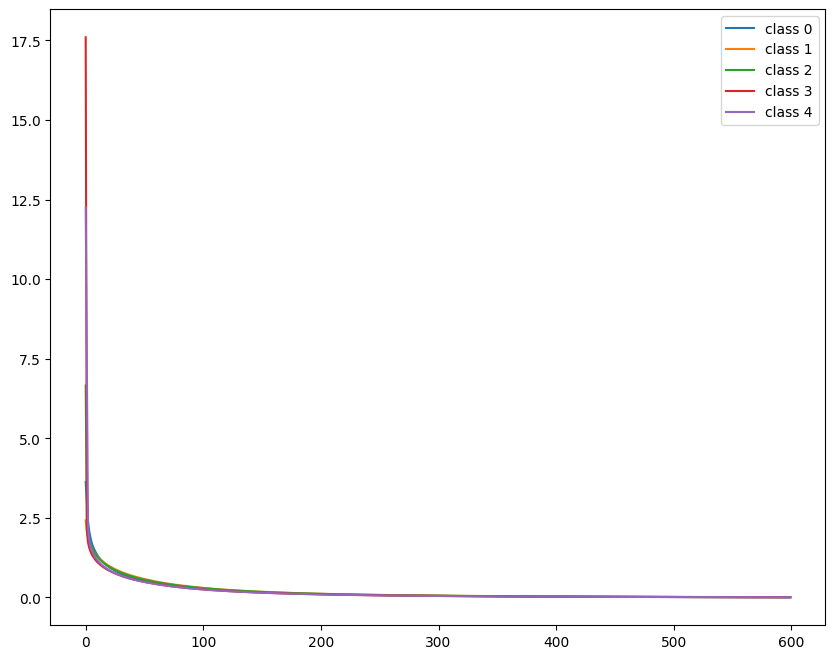

In [40]:
recenter_srs = stableranks_dict['train_H1']
# choose one sample for each label, in the training dataset
samples_class_0 = stableranks_dict['train_H1'][:700]
samples_class_1 = stableranks_dict['train_H1'][700:1400]
samples_class_2 = stableranks_dict['train_H1'][1400:2100]
samples_class_3 = stableranks_dict['train_H1'][2100:2800]
samples_class_4 = stableranks_dict['train_H1'][2800:]

plt.figure(figsize=(10,8))
plt.plot(torch.tensor(samples_class_0).mean(axis=0).detach().numpy(), label = 'class 0')
plt.plot(torch.tensor(samples_class_1).mean(axis=0).detach().numpy(), label = 'class 1')
plt.plot(torch.tensor(samples_class_2).mean(axis=0).detach().numpy(), label = 'class 2')
plt.plot(torch.tensor(samples_class_3).mean(axis=0).detach().numpy(), label = 'class 3')
plt.plot(torch.tensor(samples_class_4).mean(axis=0).detach().numpy(), label = 'class 4')
# plt.yscale('log')
plt.legend()
plt.show()

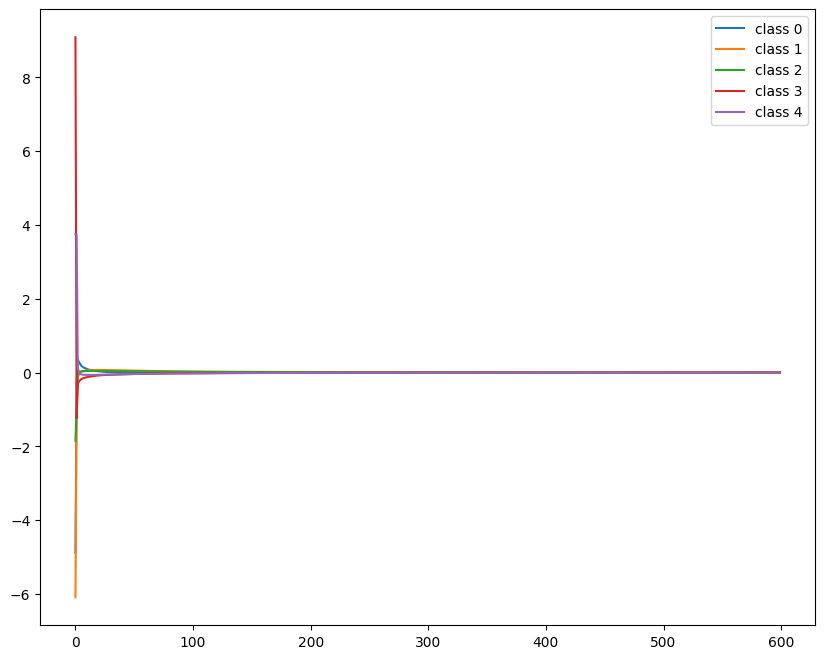

In [41]:
global_means = stableranks_dict['train_H1'].mean(axis = 0)
recenter_srs = stableranks_dict['train_H1'] - global_means
# choose one sample for each label, in the training dataset
samples_class_0 = recenter_srs[:700]
samples_class_1 = recenter_srs[700:1400]
samples_class_2 = recenter_srs[1400:2100]
samples_class_3 = recenter_srs[2100:2800]
samples_class_4 = recenter_srs[2800:]

plt.figure(figsize=(10,8))
plt.plot(torch.tensor(samples_class_0).mean(axis=0).detach().numpy(), label = 'class 0')
plt.plot(torch.tensor(samples_class_1).mean(axis=0).detach().numpy(), label = 'class 1')
plt.plot(torch.tensor(samples_class_2).mean(axis=0).detach().numpy(), label = 'class 2')
plt.plot(torch.tensor(samples_class_3).mean(axis=0).detach().numpy(), label = 'class 3')
plt.plot(torch.tensor(samples_class_4).mean(axis=0).detach().numpy(), label = 'class 4')
plt.legend()
plt.show()

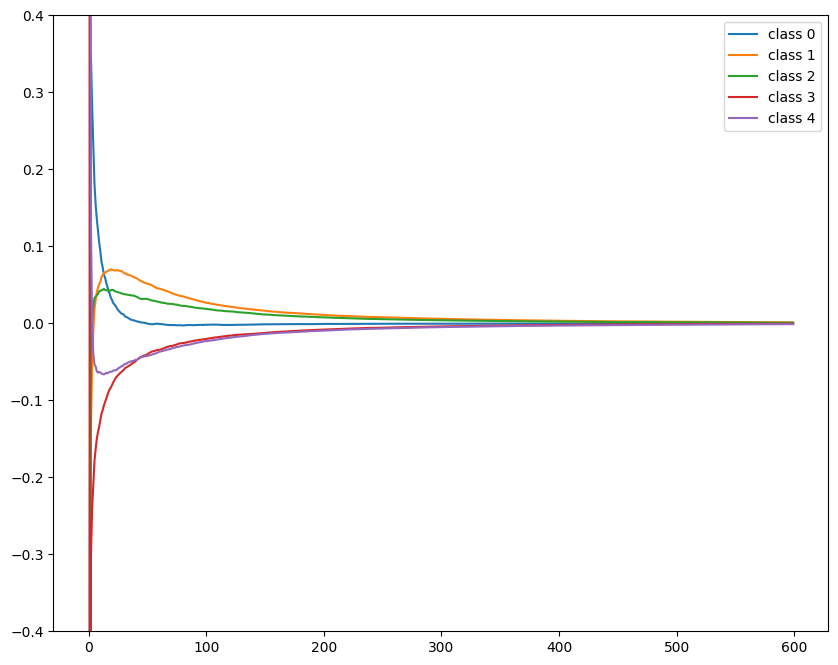

In [42]:
global_means = stableranks_dict['train_H1'].mean(axis = 0)
recenter_srs = stableranks_dict['train_H1'] - global_means
# choose one sample for each label, in the training dataset
samples_class_0 = recenter_srs[:700]
samples_class_1 = recenter_srs[700:1400]
samples_class_2 = recenter_srs[1400:2100]
samples_class_3 = recenter_srs[2100:2800]
samples_class_4 = recenter_srs[2800:]

plt.figure(figsize=(10,8))
plt.plot(torch.tensor(samples_class_0).mean(axis=0).detach().numpy(), label = 'class 0')
plt.plot(torch.tensor(samples_class_1).mean(axis=0).detach().numpy(), label = 'class 1')
plt.plot(torch.tensor(samples_class_2).mean(axis=0).detach().numpy(), label = 'class 2')
plt.plot(torch.tensor(samples_class_3).mean(axis=0).detach().numpy(), label = 'class 3')
plt.plot(torch.tensor(samples_class_4).mean(axis=0).detach().numpy(), label = 'class 4')
ylim = 0.4
plt.ylim([-ylim, ylim])
plt.legend()
plt.show()

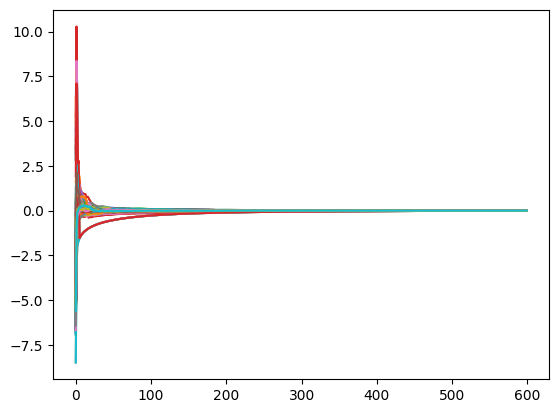

In [43]:
plt.plot(samples_class_0.T)
plt.show()

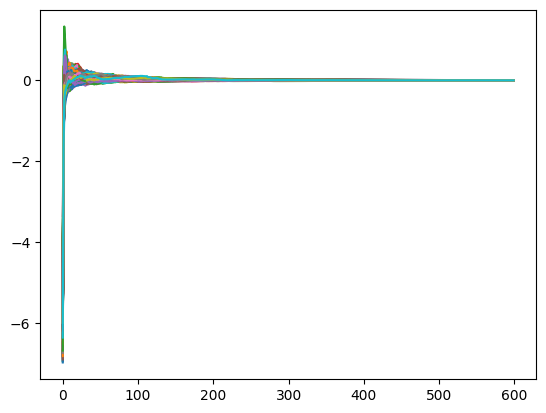

In [44]:
plt.plot(samples_class_1.T)
plt.show()

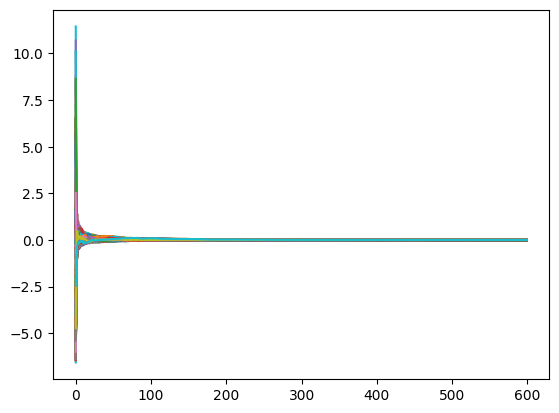

In [45]:
plt.plot(samples_class_2.T)
plt.show()

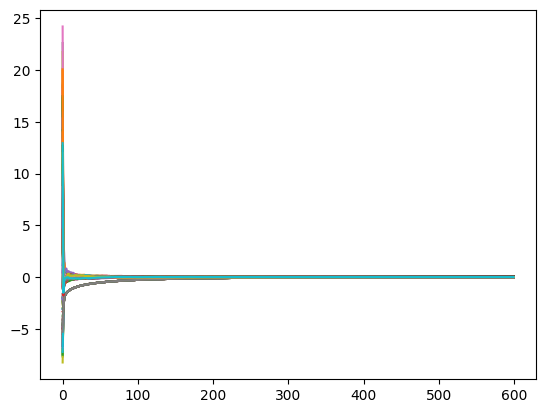

In [46]:
plt.plot(samples_class_3.T)
plt.show()

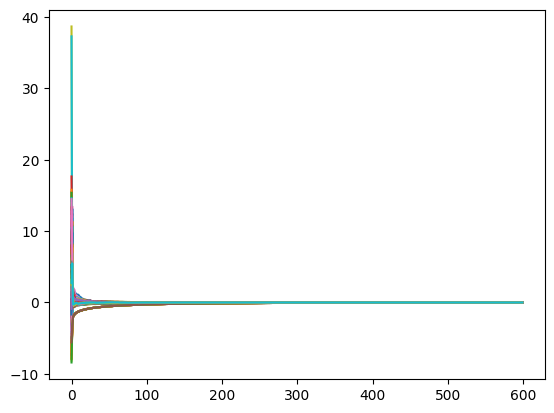

In [47]:
plt.plot(samples_class_4.T)
plt.show()

In [48]:
np.mean(loaded_data['H1_dist_pers'])
plt.figure(figsize=(10,8))
sns.heatmap(loaded_data['H1_dist_pers'])
plt.show()

NameError: name 'loaded_data' is not defined

In [ ]:
cl = 0
intra_class_dists = loaded_data['H1_dist_pers'][cl*10:cl*10+10,cl*10:cl*10+10]
plt.figure(figsize=(10,8))
sns.heatmap(intra_class_dists)
plt.show()
np.mean(intra_class_dists), np.min(intra_class_dists)

### TRY THE SAME WITH H0

In [ ]:
loss_fn = nn.CrossEntropyLoss()

H = 0
print(f' ############# {H = } ############# ')

models = [model_H0, model_H1]
model = models[H]
# model = model_H1

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05, eps=1e-06)
# list(model.parameters())[0].shape
losses = []
best_acc = 0.0

for i in range(epochs):
    for (h0, h1, cl) in batched_train:
        model.train()
        tot_loss = 0.0
        
        #calculate output
        if H == 0:
            output = model(h0, p_schedule[i])
        else:
            output = model(h1, p_schedule[i])

        #calculate loss
        loss = loss_fn(output, cl.long())

        #backprop
        optimizer.zero_grad()
        tot_loss += float(loss)
        loss.backward()
        optimizer.step()
    
    losses.append(tot_loss)
    test_acc = test_model(model, test_ds, H, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 30.0:
            torch.save(model.state_dict(), save_folder + f'H{H}_{preproc_size}_acc_{test_acc:.3f}.pth')
        print(f'\rEpoch {i+1:3}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t')
        best_acc = test_acc
    else:
        # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
        print(f"\r Epoch {i+1:3}\tloss : {loss:.5f}, p: {p_schedule[i]}", end='')

plt.plot(np.array(losses))
train_acc = test_model(model, batched_train, H, if_plot=True)
test_acc = test_model(model, test_ds, H, if_plot=True)
train_acc, test_acc

 ############# H = 0 ############# 
Epoch   1/300 --> IMPROVEMENT from 0.000 to 32.000 	
Epoch   2/300 --> IMPROVEMENT from 32.000 to 40.000 	
Epoch   7/300 --> IMPROVEMENT from 40.000 to 44.000 	
 Epoch  55	loss : 1.57135, p: inf

KeyboardInterrupt: 

In [ ]:
# IF NEEDED!
model_str = save_folder + 'H0_400_acc_32.000.pth'
saved_params = torch.load(model_str)
model.load_state_dict(saved_params)

for (h0, h1, cl) in test_ds: # 1 batch
    model.eval()
    test_output = model(h0, inf)
print(test_output.shape)
outNN_H0_distances = torch.cdist(test_output, test_output, p=inf).detach().numpy()

torch.Size([50, 5])


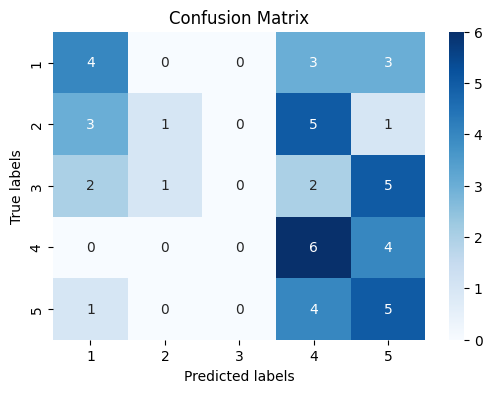

32.0

In [ ]:
test_acc = test_model(model, test_ds, H, if_plot=True)
test_acc

/tmp/ipykernel_499/1752831067.py:1: RuntimeWarning: invalid value encountered in divide
  result = np.divide(outNN_H0_distances, H0_SR_distances)#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))


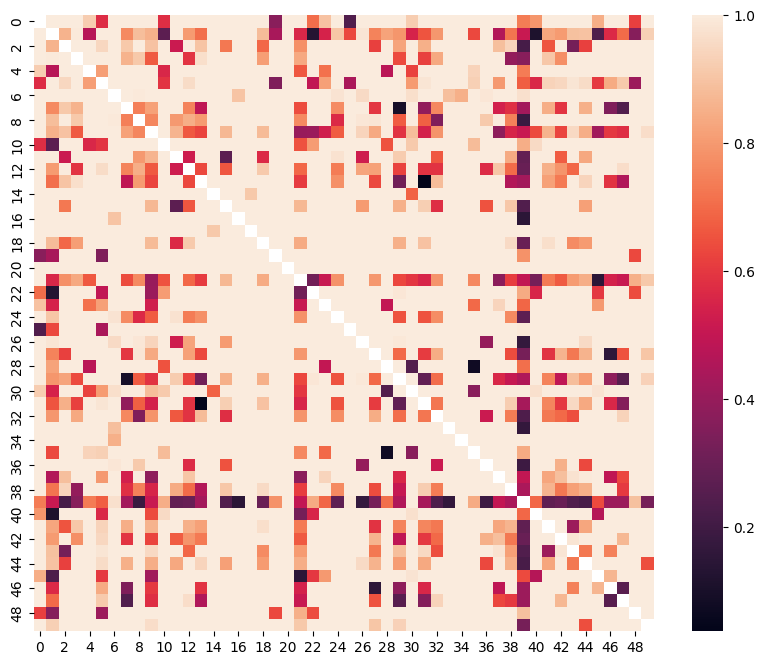

1.000000000000029 \ (array([11, 36, 43, 49]), array([36, 11, 49, 43]))


In [ ]:
result = np.divide(outNN_H0_distances, H0_SR_distances)#, out=np.full_like(H1_SR_distances, np.nan), where=(loaded_data['H1_dist_pers']!= 0))
plt.figure(figsize=(10,8))
sns.heatmap(result)
plt.show()
max_value = np.nanmax(result)
print(f'{ max_value } \ {np.where(result == max_value)}')

In [ ]:
matrix_W = H0_pers_distances
matrix_S = H0_SR_distances
matrix_E = outNN_H0_distances

resultSW = np.divide(matrix_S, matrix_W)
resultES = np.divide(matrix_E, matrix_S)

/tmp/ipykernel_499/323869619.py:5: RuntimeWarning: invalid value encountered in divide
  resultSW = np.divide(matrix_S, matrix_W)
/tmp/ipykernel_499/323869619.py:6: RuntimeWarning: invalid value encountered in divide
  resultES = np.divide(matrix_E, matrix_S)


In [ ]:
rand_row = np.random.randint(0, 50)
print(f'{rand_row = }')

row_dist_W = matrix_W[rand_row,:]
row_dist_S = matrix_S[rand_row,:]
row_dist_E = matrix_E[rand_row,:]

diff_dist_SW = row_dist_W - row_dist_S
diff_dist_ES = row_dist_S - row_dist_E

rand_row = 30


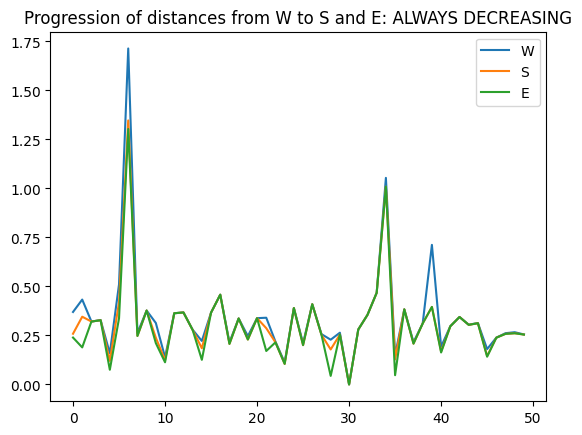

In [ ]:
plt.plot(row_dist_W, label = 'W')
plt.plot(row_dist_S, label = 'S')
plt.plot(row_dist_E, label = 'E')
plt.title("Progression of distances from W to S and E: ALWAYS DECREASING")
plt.legend()
plt.show()

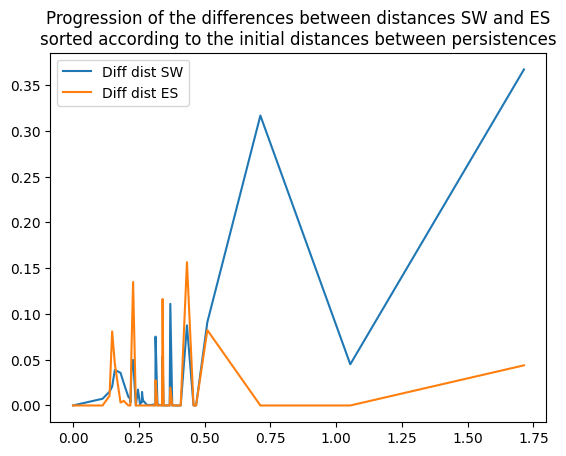

In [ ]:
# sorting by initial distances
combo_W_diffs = zip(row_dist_W, diff_dist_SW, diff_dist_ES)
sorted_combos = sorted(combo_W_diffs, key=lambda x: x[0])

x, y1, y2 = zip(*sorted_combos)
plt.plot(x, y1, label = 'Diff dist SW')
plt.plot(x, y2, label = 'Diff dist ES')
plt.title("Progression of the differences between distances SW and ES\nsorted according to the initial distances between persistences")
plt.legend()
plt.show()

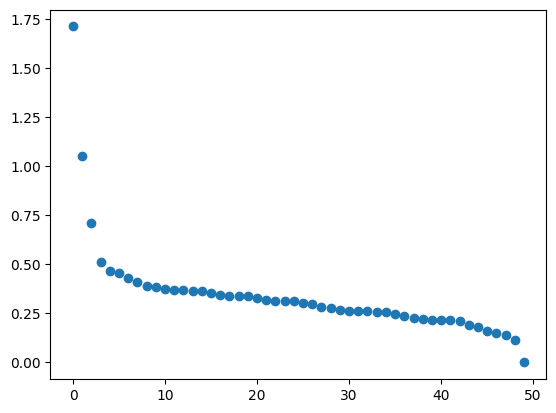

In [ ]:
plt.scatter(np.arange(len(row_dist_W)), sorted(row_dist_W, reverse=True))

### Plot

---
- Plot progressione differenze per tutte le point cloud con sulla 'x' i valori delle distanze iniziali tra le persistenze
- Matrici triangolari superiori ordinate per distanze tra persistenza e plot con persistenza sulla x e SW e ES

Scatterplot

Heatmap per i parametri della rete

Slide plot

Perslay H0 e H1 separati: benchmark coerente con i risultati

TRY 2 

rand_row = 19


/tmp/ipykernel_390/1150230851.py:12: RuntimeWarning: invalid value encountered in divide
  resultSW = np.divide(matrix_S, matrix_W)
/tmp/ipykernel_390/1150230851.py:13: RuntimeWarning: invalid value encountered in divide
  resultES = np.divide(matrix_E, matrix_S)


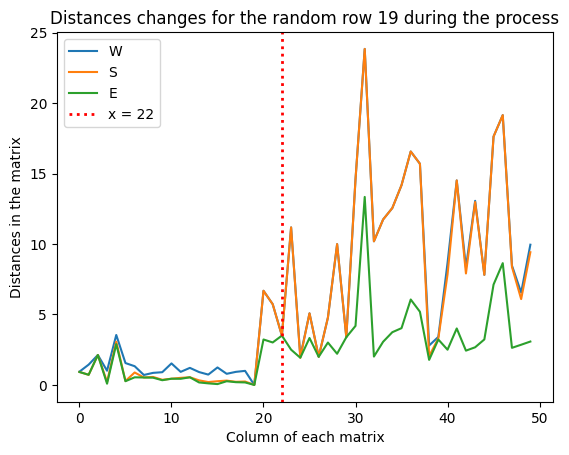

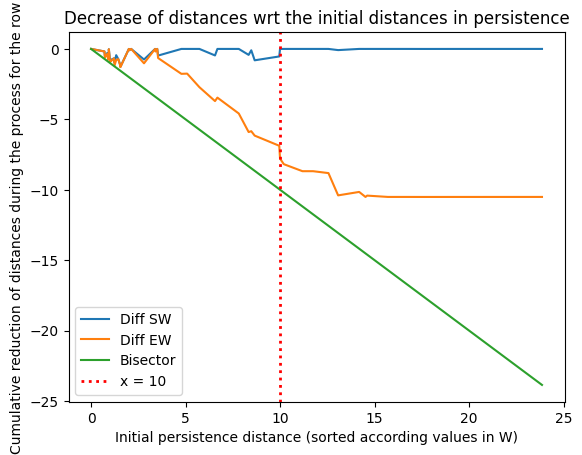

In [ ]:
# init matrices names
matrix_W = H1_pers_distances
matrix_S = H1_SR_distances
matrix_E = outNN_distances

# matrices of differences in the process
matr_SW = matrix_S - matrix_W
# matr_ES = matrix_E - matrix_S
matr_EW = matrix_E - matrix_W

# division element-wise of matrices for Lipschitzianity
resultSW = np.divide(matrix_S, matrix_W)
resultES = np.divide(matrix_E, matrix_S)

# FIX A ROW
rand_row = np.random.randint(0, 50)
print(f'{rand_row = }')

row_dist_W = matrix_W[rand_row,:]
row_dist_S = matrix_S[rand_row,:]
row_dist_E = matrix_E[rand_row,:]

diff_dist_SW = row_dist_S - row_dist_W
# diff_dist_ES = row_dist_E - row_dist_S
diff_dist_EW = row_dist_E - row_dist_W

plt.plot(row_dist_W, label = 'W')
plt.plot(row_dist_S, label = 'S')
plt.plot(row_dist_E, label = 'E')
plt.title(f"Distances changes for the random row {rand_row} during the process")
plt.axvline(x=22, color='red', linestyle=':', linewidth=2, label='x = 22')
plt.xlabel('Column of each matrix')
plt.ylabel('Distances in the matrix')
plt.legend()
plt.show()

# sorting by initial distances
combo_W_diffs = zip(row_dist_W, -row_dist_W, diff_dist_SW, diff_dist_EW)
sorted_combos = sorted(combo_W_diffs, key=lambda x: x[0])

x, neg_x, y1, y2 = zip(*sorted_combos)
plt.plot(x, y1, label = 'Diff SW')
plt.plot(x, y2, label = 'Diff EW')
plt.plot(x, neg_x, label = 'Bisector')
plt.title("Decrease of distances wrt the initial distances in persistence")
plt.axvline(x=10, color='red', linestyle=':', linewidth=2, label='x = 10')
plt.xlabel('Initial persistence distance (sorted according values in W)')
plt.ylabel(f'Cumulative reduction of distances during the process for the row {rand_row}')
plt.legend()
plt.show()

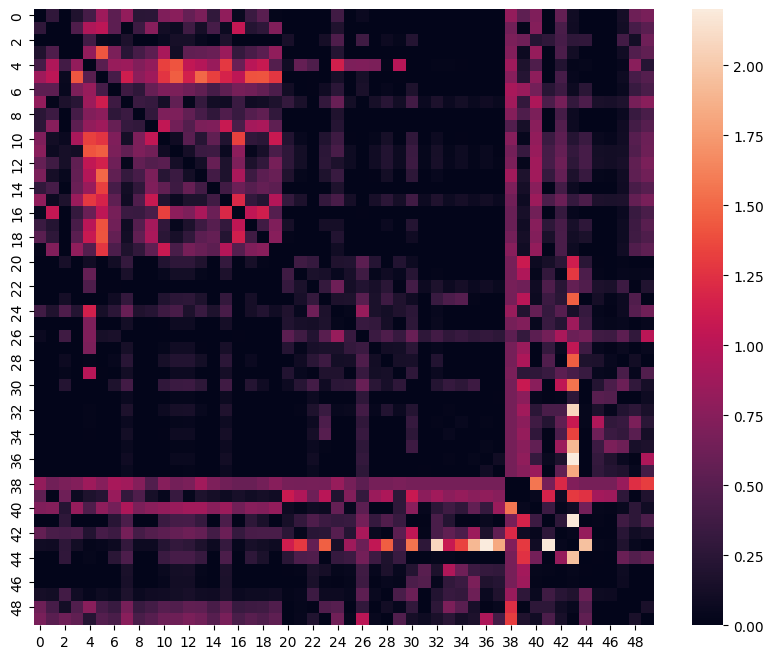

In [ ]:
diff_full_matr_SW = matrix_W - matrix_S
plt.figure(figsize=(10,8))
sns.heatmap(diff_full_matr_SW)
plt.show()

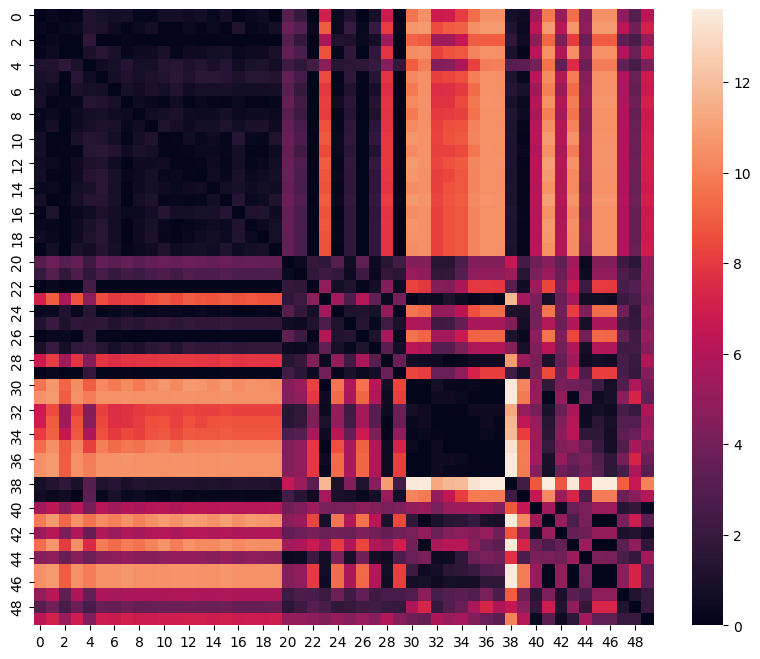

In [ ]:
diff_full_matr_ES = matrix_W - matrix_E
plt.figure(figsize=(10,8))
sns.heatmap(diff_full_matr_ES)
plt.show()

In [ ]:
#flatten without diagonal
def flat_without_diag_matr(matrix):
    mask = np.triu(np.ones(matrix.shape), k=1).astype(bool)

    # Applicazione della maschera per estrarre e appiattire gli elementi desiderati
    flat_matr = matrix[mask]
    return flat_matr

flat_W = flat_without_diag_matr(matrix_W)
flat_diff_SW = flat_without_diag_matr(matr_SW)
flat_diff_EW = flat_without_diag_matr(matr_EW)
# flat_div_SW = flat_without_diag_matr(resultSW)
# flat_div_ES = flat_without_diag_matr(resultES)
# # coherent shapes: 1225

In [ ]:
comb_diffs = zip(flat_W, -flat_W, flat_diff_SW, flat_diff_EW)
# comb_divs = zip(flat_W, flat_div_SW, flat_div_ES)
sort_comb_diffs = sorted(comb_diffs, key=lambda x: x[0]) # sorting wrt to initial W distances
# sort_comb_divs = sorted(comb_divs, key=lambda x: x[0]) # sorting wrt to initial W distances

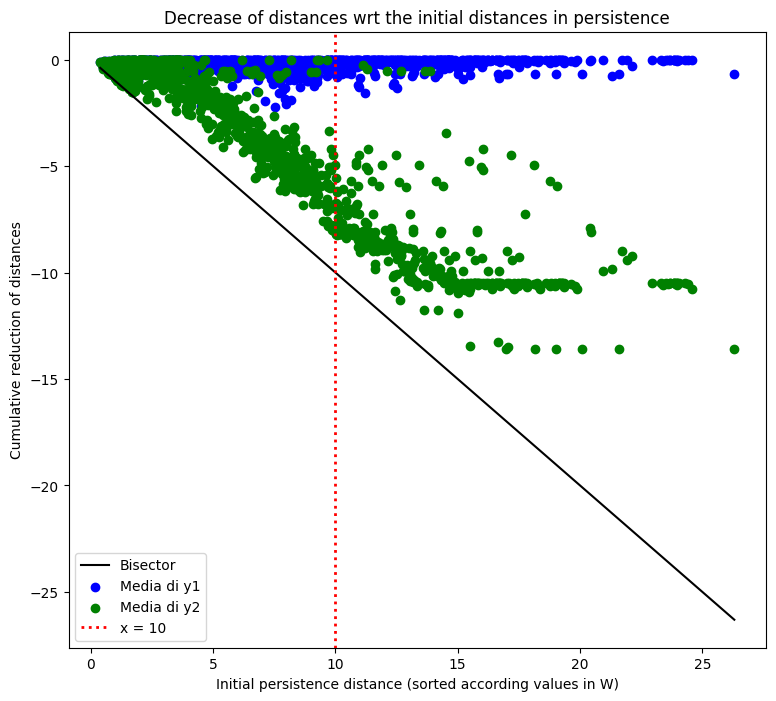

In [ ]:
# differences
x, neg_x, y1, y2 = zip(*sort_comb_diffs)
x = np.array(x)
neg_x = np.array(neg_x)
y1 = np.array(y1)
y2 = np.array(y2)
x_unique = np.unique(x)

# indexes = [np.where(x == xi)[0] for xi in x_unique]
neg_x = -x_unique
y1_means = [np.max(y1[x == xi]) for xi in x_unique]
# y1_stds = [np.std(y1[x == xi]) for xi in x_unique]
y2_means = [np.max(y2[x == xi]) for xi in x_unique]
# y2_stds = [np.std(y2[x == xi]) for xi in x_unique]

plt.figure(figsize=(9, 8))
plt.plot(x_unique, neg_x, label='Bisector', color='black')
plt.scatter(x_unique, y1_means, label='Media di y1', color='blue')
plt.scatter(x_unique, y2_means, label='Media di y2', color='green')

# Aggiungi l'area grigia per la deviazione standard
# plt.fill_between(x_unique, 
#                  np.array(y_means) - np.array(y_stds), 
#                  np.array(y_means) + np.array(y_stds), 
#                  color='gray', alpha=0.5, label='Deviazione standard')
plt.title("Decrease of distances wrt the initial distances in persistence")
plt.axvline(x=10, color='red', linestyle=':', linewidth=2, label='x = 10')
plt.xlabel('Initial persistence distance (sorted according values in W)')
plt.ylabel('Cumulative reduction of distances')
plt.legend()
plt.show()

### PERSLAY WITH H1

In [ ]:
# embedding pairs [birth, death]
def gaussian_transformation(pd):
    # Applied in the model after preproc size
    # I'm embedding the pair [birth, death] in R^15 
    embs = np.apply_along_axis(gamma_p, axis=1, arr=pd)
    return torch.tensor(embs)

def gamma_p(p):
    # params of gaussian_transformation
    ts = torch.tensor([[0., 0.], \
          [0.25, 0.], [0.25, 0.25], \
          [0.5, 0.], [0.5, 0.25], [0.5, 0.5], \
          # [0.5, 0.], [0.5, 0.5], \
          [0.75, 0.], [0.75, 0.25], [0.75, 0.5], [0.75, 0.75], \
          [1., 0.], [1., 0.25], [1., 0.5], [1., 0.75], [1., 1.]])
    sigma = 0.2
    ts = ts*0.001
    # single point computaions for gaussian transformation
    squared_distances = torch.pow(ts - p, 2).sum(dim=1)
    emb = -squared_distances/(2*sigma**2)
    emb = torch.exp(emb)
    return emb



In [ ]:
# train_preproc_H0[:100].shape
perslay_train_H0 = gaussian_transformation(train_preproc_H0)
perslay_train_H1 = gaussian_transformation(train_preproc_H1)
perslay_test_H0 = gaussian_transformation(test_preproc_H0)
perslay_test_H1 = gaussian_transformation(test_preproc_H1)

In [ ]:
np.array(data1_shuffled[0,:,0])

array([2.76189408e-04, 1.21349157e-05, 1.32515821e-02, 1.02926213e-09,
       1.12397581e-06, 2.36944930e-06])

In [ ]:
# stableranks_dict['train_H0'], ..., train_lab, test_lab
batch_size = 128

# shuffling data
combined = list(zip(perslay_train_H0, perslay_train_H1, train_lab))

# Shuffle the combined list
np.random.shuffle(combined)

# Unpack the shuffled list back into separate tensors
data1_shuffled, data2_shuffled, labels_shuffled = zip(*combined)

# Convert them back to PyTorch tensors
data1_shuffled = np.array(data1_shuffled)
data2_shuffled = np.array(data2_shuffled)
labels_shuffled = np.array(labels_shuffled)

L = train_preproc_H0.shape[0]
n_batches = L//batch_size +1
batched_train = []
for i in range(n_batches):
    batched_train.append([torch.tensor(data1_shuffled[i*batch_size:(i+1)*batch_size,:]).transpose(-1,-2),\
                        torch.tensor(data2_shuffled[i*batch_size:(i+1)*batch_size,:]).transpose(-1,-2),\
                        torch.tensor(labels_shuffled[i*batch_size:(i+1)*batch_size])])

In [ ]:
test_ds = [[torch.tensor(perslay_test_H0).transpose(-1,-2), \
            torch.tensor(perslay_test_H1).transpose(-1,-2), \
            torch.tensor(test_lab)]]

/tmp/ipykernel_390/2689096072.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ds = [[torch.tensor(perslay_test_H0).transpose(-1,-2), \
/tmp/ipykernel_390/2689096072.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(perslay_test_H1).transpose(-1,-2), \


In [ ]:
class PersImage_KTH(nn.Module):
    def __init__(self, hidden_size:int = 10, top_k:int = 10):
        super().__init__()
        self.top_k = top_k

        self.lin1 = nn.Linear(6, 30)
        self.relu_1 = torch.nn.Sigmoid()
        self.lin2 = nn.Linear(30, 80)
        self.relu_2 = torch.nn.Sigmoid()
        self.lin3 = nn.Linear(80, hidden_size)
        # self.ds_0_c = DeepSetLayer(10,5)
        self.lin_out_1 = nn.Linear(self.top_k*hidden_size, 1000)
        self.relu_out_1 = torch.nn.Sigmoid()
        self.lin_out_2 = nn.Linear(1000, 100)
        self.relu_out_2 = torch.nn.Sigmoid()
        self.lin_out_3 = nn.Linear(100, 5)
        
    def forward(self, emb_pers):
        B = emb_pers.shape[0]
        emb_pers = self.lin1(emb_pers)
        emb_pers = self.relu_1(emb_pers)
        emb_pers = self.lin2(emb_pers)
        emb_pers = self.relu_2(emb_pers)
        emb_pers = self.lin3(emb_pers)
        output, _ = torch.topk(emb_pers, self.top_k, dim=1)
        output = output.view(B, -1)
        output = self.lin_out_1(output)
        output = self.relu_out_1(output)
        output = self.lin_out_2(output)
        output = self.relu_out_2(output)
        output = self.lin_out_3(output)
        return output

pers_HiddenSize = 30
pers_topK = 50
perslay_model = PersImage_KTH(hidden_size = pers_HiddenSize, top_k = pers_topK)

In [ ]:
epochs = 300

save_folder = f'./LinfModels/'

def test_model(model, test_data, H, if_plot):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for h0, h1, cl in test_data:
            outputs = model(h1)
                
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += cl.size(0)
            # Total correct predictions
            correct += (predicted == cl).sum().item()
            target_labs = np.append(target_labs, cl)
            pred_labs = np.append(pred_labs, predicted)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    return accuracy

In [ ]:
# from torch.optim.lr_scheduler import StepLR
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=5.e-3, eps=1e-03)
# scheduler = StepLR(optimizer, step_size=20, gamma=0.8)
# list(model.parameters())[0].shape
losses = []
best_acc = 0.0

for i in range(epochs):
    for (h0, h1, cl) in batched_train:
        model.train()
        tot_loss = 0.0
        
        #calculate output
        output = perslay_model(h1)

        #calculate loss
        loss = loss_fn(output, cl.long())

        #backprop
        optimizer.zero_grad()
        tot_loss += float(loss)
        loss.backward()
        optimizer.step()
        # scheduler.step()
    
    losses.append(tot_loss)
    test_acc = test_model(perslay_model, test_ds, H, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 70.0:
            torch.save(model.state_dict(), save_folder + f'Perslay_{preproc_size}_{pers_HiddenSize}_{pers_topK}_acc_{test_acc:.3f}.pth')
        print(f'\rEpoch {i+1:3}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t')
        best_acc = test_acc
    else:
        # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
        print(f"\r Epoch {i+1:3}\tloss : {loss:.5f}, p: {p_schedule[i]}", end='')

plt.plot(np.array(losses))
train_acc = test_model(perslay_model, batched_train, H, if_plot=True)
test_acc = test_model(perslay_model, test_ds, H, if_plot=True)
train_acc, test_acc

Epoch   1/300 --> IMPROVEMENT from 0.000 to 20.000 	
 Epoch   8	loss : 1.70678, p: inf

KeyboardInterrupt: 